在之前的特征版本上进一步的处理
lgb_multi_step_1.ipynb

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast

In [3]:
data=pd.read_csv('../feature_data/feature_shanghai.csv')

KeyboardInterrupt: 

In [4]:
#在基础版本上  构建的特征
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

# 特征工程

## 位置特征

####  经纬度聚类特征

In [58]:
from sklearn.cluster import KMeans
#经纬度聚类将聚类标签作为特征     这里聚成了11类，具体数值还可以调整
def cluster_features(data):
    o_co = data[['o']]
    d_co = data[['d']]

    o_co.columns = ['co']
    d_co.columns = ['co']

    data['od_cluster', 'd_cluster'] = np.nan


    all_co = pd.concat([d_co, o_co])['co'].unique()
    X = pd.DataFrame()
    X['lng'] = pd.Series(all_co).apply(lambda x: float(x.split(',')[0]))
    X['lat'] = pd.Series(all_co).apply(lambda x: float(x.split(',')[0]))
    clf_KMeans = KMeans(n_clusters=11)#构造聚类器
    cluster = clf_KMeans.fit_predict(X)#聚类
    index = 0
    for co in tqdm(all_co):
        data.loc[(data['o'] == co), 'o_cluster'] = cluster[index]
        data.loc[(data['d'] == co), 'd_cluster'] = cluster[index]
        index +=1
    return data
data = cluster_features(data)

100%|██████████████████████████████████████████████████████████████████████████████| 5075/5075 [06:21<00:00, 13.31it/s]


#### 地点热度信息
之前发现一个地点作为起点的次数是强特，照着这个热度思考挖掘，还能发现很多的特征

In [84]:

# ----------------- 计数 -------------------

# 获取目的地的热度
def get_eloc_count(train, result):
    train = train[~train.d.isnull()]
    eloc_count = train.groupby('d', as_index=False)['sid'].agg({'eloc_count': 'count'})
    result = pd.merge(result, eloc_count, on='d', how='left')
    return result

# 获取出发地热度
def get_sloc_count(train, result):
    sloc_count = train.groupby('o', as_index=False)['sid'].agg({'sloc_count': 'count'})
    result = pd.merge(result, sloc_count, on='o', how='left')
    return result

# 获取出发地作为目的地的热度
def get_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    sloc_as_eloc_count = train.groupby('d', as_index=False)['sid'].agg({'sloc_as_eloc_count': 'count'})
    sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, sloc_as_eloc_count, on='o', how='left')
    return result

# 获取目的地作为出发地的热度
def get_eloc_as_sloc_count(train, result):
    eloc_as_sloc_count = train.groupby('o', as_index=False)['sid'].agg({'eloc_as_sloc_count': 'count'})
    eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, eloc_as_sloc_count, on='d', how='left')
    return result

# 获取出发地->目的地地址对的热度
def get_sloc_eloc_count(train, result):
    train = train[~train.d.isnull()]
    sloc_eloc_count = train.groupby(['o', 'd'], as_index=False)['sid'].agg({'sloc_eloc_count': 'count'})
    result = pd.merge(result, sloc_eloc_count, on=['o', 'd'], how='left')
    return result

# 获取目的地->出发地地址对的热度（返程次数）
def get_eloc_sloc_count(train, result):
    train = train[~train.d.isnull()]
    eloc_sloc_count = train.groupby(['o', 'd'], as_index=False)['sid'].agg({'eloc_sloc_count': 'count'})
    eloc_sloc_count.rename(columns={'o': 'd', 'd': 'o'}, inplace=True)
    result = pd.merge(result, eloc_sloc_count, on=['o', 'd'], how='left')
    return result

# 获取目的地的用户热度
def get_eloc_user_count(train, result):
    train = train[~train.d.isnull()]
    eloc_user_count = train.groupby(['d'], as_index=False)['pid'].agg({'eloc_user_count': lambda x: np.unique(x).size})
    result = pd.merge(result, eloc_user_count, on='d', how='left')
    return result

# 获取出发地的用户热度
def get_sloc_user_count(train, result):
    sloc_user_count = train.groupby(['o'], as_index=False)['pid'].agg({'sloc_user_count': lambda x: np.unique(x).size})
    result = pd.merge(result, sloc_user_count, on='o', how='left')
    return result

# 获取出发地作为目的地的用户热度
def get_sloc_as_eloc_user_count(train, result):
    train = train[~train.d.isnull()]
    sloc_as_eloc_user_count = train.groupby('d', as_index=False)['pid'].agg({'sloc_as_eloc_user_count': lambda x: np.unique(x).size})
    sloc_as_eloc_user_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, sloc_as_eloc_user_count, on='o', how='left')
    return result

# 获取目的地作为出发地的用户热度
def get_eloc_as_sloc_user_count(train, result):
    eloc_as_sloc_user_count = train.groupby('o', as_index=False)['pid'].agg({'eloc_as_sloc_user_count': lambda x: np.unique(x).size})
    eloc_as_sloc_user_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, eloc_as_sloc_user_count, on='d', how='left')
    return result

# 获取出发地->目的地地址对的用户热度
def get_sloc_eloc_user_count(train, result):
    train = train[~train.d.isnull()]
    sloc_eloc_user_count = train.groupby(['o', 'd'], as_index=False)['pid'].agg({'sloc_eloc_user_count': lambda x: np.unique(x).size})
    result = pd.merge(result, sloc_eloc_user_count, on=['o', 'd'], how='left')
    return result

# 获取目的地->出发地地址对的用户热度（返程用户数）
def get_eloc_sloc_user_count(train, result):
    train = train[~train.d.isnull()]
    eloc_sloc_user_count = train.groupby(['o', 'd'], as_index=False)['pid'].agg({'eloc_sloc_user_count': lambda x: np.unique(x).size})
    eloc_sloc_user_count.rename(columns={'o': 'd', 'd': 'o'}, inplace=True)
    result = pd.merge(result, eloc_sloc_user_count, on=['o', 'd'], how='left')
    return result

# 获取从某个地方出发的目的地个数
def get_sloc_eloccount(train, result):
    train = train[~train.d.isnull()]
    sloc_eloccount = train.groupby('o', as_index=False)['d'].agg({'sloc_eloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, sloc_eloccount, on='o', how='left')
    return result

# 获取到某个地方结束的出发地个数
def get_eloc_sloccount(train, result):
    train = train[~train.d.isnull()]
    eloc_sloccount = train.groupby('d', as_index=False)['o'].agg({'eloc_sloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, eloc_sloccount, on='d', how='left')
    return result

# 获取目的地在各小时段的订单数
def get_eloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_count = train.groupby(['d', 'req_time_hour'], as_index=False)['sid'].agg({'eloc_hour_count': 'count'})
    result = pd.merge(result, eloc_hour_count, on=['d', 'req_time_hour'], how='left')
    return result

# 获取出发地在各小时段的订单数
def get_sloc_hour_count(train, result):
    sloc_hour_count = train.groupby(['o', 'req_time_hour'], as_index=False)['sid'].agg({'sloc_hour_count': 'count'})
    result = pd.merge(result, sloc_hour_count, on=['o', 'req_time_hour'], how='left')
    return result

# 获取出发地->目的地地址对的小时热度
def get_sloc_eloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    sloc_eloc_hour_count = train.groupby(['o', 'd', 'req_time_hour'], as_index=False)['pid'].agg({'sloc_eloc_hour_count': 'count'})
    result = pd.merge(result, sloc_eloc_hour_count, on=['o', 'd', 'req_time_hour'], how='left')
    return result

# 获取目的地->出发地地址对的小时热度（返程次数）
def get_eloc_sloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    eloc_sloc_hour_count = train.groupby(['o', 'd', 'req_time_hour'], as_index=False)['pid'].agg({'eloc_sloc_hour_count': 'count'})
    eloc_sloc_hour_count.rename(columns={'o': 'd', 'd': 'o'}, inplace=True)
    result = pd.merge(result, eloc_sloc_hour_count, on=['o', 'd', 'req_time_hour'], how='left')
    return result

# 获取目的地在各小时段的用户数
def get_eloc_hour_user_count(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_user_count = train.groupby(['d', 'req_time_hour'], as_index=False)['pid'].agg({'eloc_hour_user_count': 
                                                                                    lambda x: np.unique(x).size})
    result = pd.merge(result, eloc_hour_user_count, on=['d', 'req_time_hour'], how='left')
    return result

# 获取出发地在各小时段的用户数
def get_sloc_hour_user_count(train, result):
    sloc_hour_user_count = train.groupby(['o', 'req_time_hour'], as_index=False)['pid'].agg({'sloc_hour_user_count': 
                                                                                    lambda x: np.unique(x).size})
    result = pd.merge(result, sloc_hour_user_count, on=['o', 'req_time_hour'], how='left')
    return result

# 获取出发地->目的地地址对的用户小时热度
def get_sloc_eloc_hour_user_count(train, result):
    train = train[~train.d.isnull()]
    sloc_eloc_hour_user_count = train.groupby(['o', 'd', 'req_time_hour'], as_index=False)['pid'].agg({'sloc_eloc_hour_user_count': lambda x: np.unique(x).size})
    result = pd.merge(result, sloc_eloc_hour_user_count, on=['o', 'd', 'req_time_hour'], how='left')
    return result

# 获取目的地->出发地地址对的用户小时热度（返程用户数）
def get_eloc_sloc_hour_user_count(train, result):
    train = train[~train.d.isnull()]
    eloc_sloc_hour_user_count = train.groupby(['o', 'd', 'req_time_hour'], as_index=False)['pid'].agg({'eloc_sloc_hour_user_count': lambda x: np.unique(x).size})
    eloc_sloc_hour_user_count.rename(columns={'o': 'd', 'd': 'o'}, inplace=True)
    result = pd.merge(result, eloc_sloc_hour_user_count, on=['o', 'd', 'req_time_hour'], how='left') # 9
    return result

# 获取从某个地方出发每个小时的目的地个数
def get_sloc_hour_eloccount(train, result):
    train = train[~train.d.isnull()]
    sloc_hour_eloccount = train.groupby(['o', 'req_time_hour'], as_index=False)['d'].agg({'sloc_hour_eloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, sloc_hour_eloccount, on=['o', 'req_time_hour'], how='left')
    return result

# 获取到某个地方结束每个小时的出发地个数
def get_eloc_hour_sloccount(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_sloccount = train.groupby(['d', 'req_time_hour'], as_index=False)['o'].agg({'eloc_hour_sloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, eloc_hour_sloccount, on=['d', 'req_time_hour'], how='left')
    return result

# ----------------- 统计 -------------------

# 获取从某个地点出发的距离统计
def get_sloc_distance_stat(train, result):
    train = train[~train.d.isnull()]
    sloc_distance_stat = train.groupby(['o'], as_index=False)['od_manhattan_distance_detail'].agg({'sloc_distance_max': 'max', 'sloc_distance_min': 'min', 'sloc_distance_mean': 'mean'})
    result = pd.merge(result, sloc_distance_stat, on=['o'], how='left')
    return result

# 获取到某个地点结束的距离统计
def get_eloc_distance_stat(train, result):
    train = train[~train.d.isnull()]
    eloc_distance_stat = train.groupby(['d'], as_index=False)['od_manhattan_distance_detail'].agg({'eloc_distance_max': 'max', 'eloc_distance_min': 'min', 'eloc_distance_mean': 'mean'})
    result = pd.merge(result, eloc_distance_stat, on=['d'], how='left')
    return result

# 获取从某个地点出发的小时段距离统计
def get_sloc_hour_distance_stat(train, result):
    train = train[~train.d.isnull()]
    sloc_hour_distance_stat = train.groupby(['o', 'req_time_hour'], as_index=False)['od_manhattan_distance_detail'].agg({'sloc_hour_distance_max': 'max', 'sloc_hour_distance_min': 'min', 'sloc_hour_distance_mean': 'mean'})
    result = pd.merge(result, sloc_hour_distance_stat, on=['o', 'req_time_hour'], how='left')
    return result

# 获取到某个地点结束的小时段距离统计
def get_eloc_hour_distance_stat(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_distance_stat = train.groupby(['d', 'req_time_hour'], as_index=False)['od_manhattan_distance_detail'].agg({'eloc_hour_distance_max': 'max', 'eloc_hour_distance_min': 'min', 'eloc_hour_distance_mean': 'mean'})
    result = pd.merge(result, eloc_hour_distance_stat, on=['d', 'req_time_hour'], how='left')
    return result

# 获取从某个地点出发的小时均值
def get_sloc_hour_mean(train, result):
    sloc_hour_mean = train.groupby(['o'], as_index=False)['req_time_hour'].agg({'sloc_hour_mean': 'mean'})
    result = pd.merge(result, sloc_hour_mean, on=['o'], how='left')
    return result

# 获取到某个地点结束的小时均值
def get_eloc_hour_mean(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_mean = train.groupby(['d'], as_index=False)['req_time_hour'].agg({'eloc_hour_mean': 'mean'})
    result = pd.merge(result, eloc_hour_mean, on=['d'], how='left')
    return result

# 获取从某个点出发到某个地点结束的小时均值
def get_sloc_eloc_hour_mean(train, result):
    train = train[~train.d.isnull()]
    sloc_eloc_hour_mean = train.groupby(['o', 'd'], as_index=False)['req_time_hour'].agg({'sloc_eloc_hour_mean': 'mean'})
    result = pd.merge(result, sloc_eloc_hour_mean, on=['o', 'd'], how='left')
    return result

# ----------------- 排序 -------------------
# 分组排序
def rank(data, feat1, feat2, rank_name='rank', ascending=True):
    if type(feat1) == list: feat = feat1 + [feat2]
    else: feat = [feat1, feat2]
    use_feat = list(set(feat + ['sid', 'd']))
    datatmp = data[use_feat]
    datatmp.sort_values(feat, inplace=True, ascending=ascending)
    datatmp[rank_name] = range(datatmp.shape[0])
    min_rank = datatmp.groupby(feat1, as_index=False)[rank_name].agg({'min_rank': 'min'})
    datatmp = pd.merge(datatmp, min_rank, on=feat1, how='left')
    datatmp[rank_name] = datatmp[rank_name] - datatmp['min_rank']
    data = pd.merge(data, datatmp[['sid', 'd', rank_name]], on=['sid', 'd'], how='left')
    # del data['min_rank']
    return data

# 获取到某个目的地的距离排序
def get_eloc_distance_rank(result):
    result = rank(result, 'd', 'od_manhattan_distance_detail', rank_name='eloc_distance_rank', ascending=False)
    return result

# 获取从某个地点出发的距离排序
def get_sloc_distance_rank(result):
    result = rank(result, 'o', 'od_manhattan_distance_detail', rank_name='sloc_distance_rank', ascending=False)
    return result

# 获取到某个目的地的小时段距离排序
def get_eloc_hour_distance_rank(result):
    result = rank(result, ['d', 'req_time_hour'], 'od_manhattan_distance_detail', rank_name='eloc_hour_distance_rank', ascending=False)
    return result

# 获取从某个目的地出发的小时段距离排序
def get_sloc_hour_distance_rank(result):
    result = rank(result, ['o', 'req_time_hour'], 'od_manhattan_distance_detail', rank_name='sloc_hour_distance_rank', ascending=False)
    return result

# 获取从某个地点出发的小时段排序
def get_sloc_hour_rank(result):
    result = rank(result, 'o', 'req_time_hour', rank_name='sloc_hour_rank', ascending=False)
    return result

# 获取到某个目的地结束的小时段排序
def get_eloc_hour_rank(result):
    result = rank(result, 'd', 'req_time_hour', rank_name='eloc_hour_rank', ascending=False)
    return result

# 获取从某个地点出发到某个地点结束的小时段排序
def get_sloc_eloc_hour_rank(result):
    result = rank(result, ['o', 'd'], 'req_time_hour', rank_name='sloc_eloc_hour_rank', ascending=False)
    return result

# ----------------- 差值 -------------------

# 获取距离与从某个点出发距离统计值的绝对差值
def get_sloc_distance_stat_sub(result):
    result['sloc_distance_mean_sub'] = (result['od_manhattan_distance_detail'] - result['sloc_distance_mean'])
    result['sloc_distance_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['sloc_distance_mean']).abs()
    return result

# 获取距离与到某个点结束距离统计值的绝对差值
def get_eloc_distance_stat_sub(result):
    result['eloc_distance_mean_sub'] = (result['od_manhattan_distance_detail'] - result['eloc_distance_mean'])
    result['eloc_distance_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['eloc_distance_mean']).abs()
    return result

# 获取距离与从某个点出发距离统计值的各小时段绝对差值
def get_sloc_hour_distance_stat_sub(result):
    result['sloc_hour_distance_mean_sub'] = (result['od_manhattan_distance_detail'] - result['sloc_hour_distance_mean'])
    result['sloc_hour_distance_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['sloc_hour_distance_mean']).abs()
    return result

# 获取距离与到某个点结束距离统计值的各小时段绝对差值
def get_eloc_hour_distance_stat_sub(result):
    result['eloc_hour_distance_mean_sub'] = (result['od_manhattan_distance_detail'] - result['eloc_hour_distance_mean'])
    result['eloc_hour_distance_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['eloc_hour_distance_mean']).abs()
    return result

# 获取小时段与从某个点出发的小时均值的绝对差值
def get_hour_sloc_hour_mean_sub(result):
    result['hour_sloc_hour_mean_sub'] = (result['req_time_hour'] - result['sloc_hour_mean'])
    result['hour_sloc_hour_mean_sub_abs'] = (result['req_time_hour'] - result['sloc_hour_mean']).abs()
    return result

# 获取小时段与到某个点结束的小时均值的绝对差值
def get_hour_eloc_hour_mean_sub(result):
    result['hour_eloc_hour_mean_sub'] = (result['req_time_hour'] - result['eloc_hour_mean'])
    result['hour_eloc_hour_mean_sub_abs'] = (result['req_time_hour'] - result['eloc_hour_mean']).abs()
    return result

# 获取小时段与从某个点出发到某个点结束的小时均值的绝对差值
def get_hour_sloc_eloc_hour_mean_sub(result):
    result['hour_sloc_eloc_hour_mean_sub'] = (result['req_time_hour'] - result['sloc_eloc_hour_mean'])
    result['hour_sloc_eloc_hour_mean_sub_abs'] = (result['req_time_hour'] - result['sloc_eloc_hour_mean']).abs()
    return result

# ----------------- 比例 ------------------- 

# 获取从某个地点出发到某个地点结束的个数与从这个点出发的个数的比例
def get_sloc_eloc_count_ratio(result):
    result['sloc_eloc_count_ratio'] = result['sloc_eloc_count_x'] / result['sloc_count_x']
    return result;

# 获取从某个地点出发的小时段个数与从这个地方出发的个数的比例
def get_sloc_hour_count_ratio(result):
    result['sloc_hour_count_ratio'] = result['sloc_hour_count'] / result['sloc_count_x']
    return result

# 获取到某个目的地的小时段个数与到某个目的地的个数的比例
def get_eloc_hour_count_ratio(result):
    result['eloc_hour_count_ratio'] = result['eloc_hour_count'] / result['eloc_count_x']
    return result

In [85]:
data=get_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)

data=get_sloc_as_eloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_as_sloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_eloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_sloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_eloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_sloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_eloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_sloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_hour_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_hour_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_eloc_hour_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_sloc_hour_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_hour_eloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_hour_sloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_hour_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_hour_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_hour_mean(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_hour_mean(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_sloc_eloc_hour_mean(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance_detail']], data)
data=get_eloc_distance_rank(data)
data=get_sloc_distance_rank(data)
data=get_eloc_hour_distance_rank(data)
data=get_sloc_hour_distance_rank(data)
data=get_sloc_hour_rank(data)
data=get_eloc_hour_rank(data)
data=get_sloc_eloc_hour_rank(data)
data=get_sloc_distance_stat_sub(data)
data=get_eloc_distance_stat_sub(data)
data=get_sloc_hour_distance_stat_sub(data)
data=get_eloc_hour_distance_stat_sub(data)
data=get_hour_sloc_hour_mean_sub(data)
data=get_hour_eloc_hour_mean_sub(data)
data=get_hour_sloc_eloc_hour_mean_sub(data)
data=get_sloc_eloc_count_ratio(data)
data=get_sloc_hour_count_ratio(data)
data=get_eloc_hour_count_ratio(data)

## 经纬度特征

In [15]:
import Geohash as geohash

def rank(data, feat1, feat2, rank_name='rank', ascending=True):
    if type(feat1) == list: feat = feat1 + [feat2]
    else: feat = [feat1, feat2]
    use_feat = list(set(feat + ['sid', 'd']))
    datatmp = data[use_feat]
    datatmp.sort_values(feat, inplace=True, ascending=ascending)
    datatmp[rank_name] = range(datatmp.shape[0])
    min_rank = datatmp.groupby(feat1, as_index=False)[rank_name].agg({'min_rank': 'min'})
    datatmp = pd.merge(datatmp, min_rank, on=feat1, how='left')
    datatmp[rank_name] = datatmp[rank_name] - datatmp['min_rank']
    data = pd.merge(data, datatmp[['sid', 'd', rank_name]], on=['sid', 'd'], how='left')
    # del data['min_rank']
    return data


# ----------------- 经纬度 -------------------

# 获取目的地的经纬度
def get_eloc_latlon(result):
  
    result['eloc_lon'] = result['o_lng']
    result['eloc_lat'] = result['o_lat']
    return result

# 获取出发地的经纬度
def get_sloc_latlon(result):
    result['sloc_lon'] = result['d_lng']
    result['sloc_lat'] = result['d_lat']
    return result

# ----------------- 方向 -------------------

# 获取出发地与目的地的经纬度差
def get_eloc_sloc_latlon_sub(result):
    # sloc_latlon = result['geohashed_start_loc'].apply(lambda x: geohash.decode_exactly(x)[:2])
    # sloc_lat = sloc_latlon.apply(lambda x: float(x[0]))
    # sloc_lon = sloc_latlon.apply(lambda x: float(x[1]))
    # eloc_latlon = result['geohashed_end_loc'].apply(lambda x: geohash.decode_exactly(x)[:2])
    # eloc_lat = eloc_latlon.apply(lambda x: float(x[0]))
    # eloc_lon = eloc_latlon.apply(lambda x: float(x[1]))
    result['eloc_sloc_lat_sub'] = result['eloc_lat'] - result['sloc_lat']
    result['eloc_sloc_lon_sub'] = result['eloc_lon'] - result['sloc_lon']

    return result

# 获取出发地与目的地的斜率
def get_eloc_sloc_slope(result):
    result['eloc_sloc_latlon_slope'] = result['eloc_sloc_lat_sub'] / result['eloc_sloc_lon_sub']
    return result


# 获取经纬度差与距离的商
def get_eloc_sloc_latlon_sub_divide_distance(result):
    result['eloc_sloc_lat_sub_divide_distance'] = result['eloc_sloc_lat_sub'] / result['od_manhattan_distance']
    result['eloc_sloc_lon_sub_divide_distance'] = result['eloc_sloc_lon_sub'] / result['od_manhattan_distance']
    result['eloc_sloc_lat_sub_divide_manhattan'] = result['eloc_sloc_lat_sub'] / result['od_manhattan_distance_detail']
    result['eloc_sloc_lon_sub_divide_manhattan'] = result['eloc_sloc_lon_sub'] / result['od_manhattan_distance_detail']
    return result

# 获取方向角
def get_bearing_array(result):
    result['degree'] = np.arctan2(result['eloc_sloc_lat_sub'], result['eloc_sloc_lon_sub'])
    return result

# ----------------- 统计 -------------------

# 获取用户出发的距离统计
def get_user_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    user_lat_sub_stat = train.groupby(['pid', 'o'], as_index=False)['eloc_sloc_lat_sub'].agg({'user_lat_sub_max': 'max', 'user_lat_sub_min': 'min', 'user_lat_sub_mean': 'mean'})
    result = pd.merge(result, user_lat_sub_stat, on=['pid', 'o'], how='left')
    user_lon_sub_stat = train.groupby(['pid', 'o'], as_index=False)['eloc_sloc_lon_sub'].agg({'user_lon_sub_max': 'max', 'user_lon_sub_min': 'min', 'user_lon_sub_mean': 'mean'})
    result = pd.merge(result, user_lon_sub_stat, on=['pid', 'o'], how='left')
    return result

# 获取用户从某个地点出发的距离统计
def get_user_sloc_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    user_sloc_lat_sub_stat = train.groupby(['pid', 'o'], as_index=False)['eloc_sloc_lat_sub'].agg({'user_sloc_lat_sub_max': 'max', 'user_sloc_lat_sub_min': 'min', 'user_sloc_lat_sub_mean': 'mean'}) # 8 7 kong
    # user_sloc_lat_sub_stat = train.groupby(['userid', 'geohashed_start_loc'], as_index=False)['eloc_sloc_lat_sub'].agg({'user_sloc_lat_sub_mean': 'mean'})
    result = pd.merge(result, user_sloc_lat_sub_stat, on=['pid', 'o'], how='left')
    user_sloc_lon_sub_stat = train.groupby(['pid', 'o'], as_index=False)['eloc_sloc_lon_sub'].agg({'user_sloc_lon_sub_max': 'max', 'user_sloc_lon_sub_min': 'min', 'user_sloc_lon_sub_mean': 'mean'})
    result = pd.merge(result, user_sloc_lon_sub_stat, on=['pid', 'o'], how='left')
    return result

# 获取用户到某个地点结束的距离统计
def get_user_eloc_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    user_eloc_lat_sub_stat = train.groupby(['pid', 'd'], as_index=False)['eloc_sloc_lat_sub'].agg({'user_eloc_lat_sub_max': 'max', 'user_eloc_lat_sub_min': 'min', 'user_eloc_lat_sub_mean': 'mean'})
    result = pd.merge(result, user_eloc_lat_sub_stat, on=['pid', 'd'], how='left')
    user_eloc_lon_sub_stat = train.groupby(['pid', 'd'], as_index=False)['eloc_sloc_lon_sub'].agg({'user_eloc_lon_sub_max': 'max', 'user_eloc_lon_sub_min': 'min', 'user_eloc_lon_sub_mean': 'mean'})
    result = pd.merge(result, user_eloc_lon_sub_stat, on=['pid', 'd'], how='left')
    return result

# 获取用户从某个地点出发的小时段距离统计
def get_user_sloc_hour_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    user_sloc_hour_lat_sub_stat = train.groupby(['pid', 'o', 'req_time_hour'], as_index=False)['eloc_sloc_lat_sub'].agg({'user_sloc_hour_lat_sub_max': 'max', 'user_sloc_hour_lat_sub_min': 'min', 'user_sloc_hour_lat_sub_mean': 'mean'})
    result = pd.merge(result, user_sloc_hour_lat_sub_stat, on=['pid', 'o', 'req_time_hour'], how='left')
    user_sloc_hour_lon_sub_stat = train.groupby(['pid', 'o', 'req_time_hour'], as_index=False)['eloc_sloc_lon_sub'].agg({'user_sloc_hour_lon_sub_max': 'max', 'user_sloc_hour_lon_sub_min': 'min', 'user_sloc_hour_lon_sub_mean': 'mean'})
    result = pd.merge(result, user_sloc_hour_lon_sub_stat, on=['pid', 'o', 'req_time_hour'], how='left')
    return result

# 获取用户到某个地点结束的小时段距离统计
def get_user_eloc_hour_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    user_eloc_hour_lat_sub_stat = train.groupby(['pid', 'd', 'req_time_hour'], as_index=False)['eloc_sloc_lat_sub'].agg({'user_eloc_hour_lat_sub_max': 'max', 'user_eloc_hour_lat_sub_min': 'min', 'user_eloc_hour_lat_sub_mean': 'mean'}) # 4 4 6
    result = pd.merge(result, user_eloc_hour_lat_sub_stat, on=['pid', 'd', 'req_time_hour'], how='left')
    user_eloc_hour_lon_sub_stat = train.groupby(['pid', 'd', 'req_time_hour'], as_index=False)['eloc_sloc_lon_sub'].agg({'user_eloc_hour_lon_sub_max': 'max', 'user_eloc_hour_lon_sub_min': 'min', 'user_eloc_hour_lon_sub_mean': 'mean'}) # 2 7 6
    result = pd.merge(result, user_eloc_hour_lon_sub_stat, on=['pid', 'd', 'req_time_hour'], how='left')
    return result

# 获取从某个地点出发的距离统计
def get_sloc_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    sloc_lat_sub_stat = train.groupby(['o'], as_index=False)['eloc_sloc_lat_sub'].agg({'sloc_lat_sub_max': 'max', 'sloc_lat_sub_min': 'min', 'sloc_lat_sub_mean': 'mean'})
    result = pd.merge(result, sloc_lat_sub_stat, on=['o'], how='left')
    sloc_lon_sub_stat = train.groupby(['o'], as_index=False)['eloc_sloc_lon_sub'].agg({'sloc_lon_sub_max': 'max', 'sloc_lon_sub_min': 'min', 'sloc_lon_sub_mean': 'mean'})
    result = pd.merge(result, sloc_lon_sub_stat, on=['o'], how='left')
    return result

# 获取到某个地点结束的距离统计
def get_eloc_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    eloc_lat_sub_stat = train.groupby(['d'], as_index=False)['eloc_sloc_lat_sub'].agg({'eloc_lat_sub_max': 'max', 'eloc_lat_sub_min': 'min', 'eloc_lat_sub_mean': 'mean'})
    result = pd.merge(result, eloc_lat_sub_stat, on=['d'], how='left')
    eloc_lon_sub_stat = train.groupby(['d'], as_index=False)['eloc_sloc_lon_sub'].agg({'eloc_lon_sub_max': 'max', 'eloc_lon_sub_min': 'min', 'eloc_lon_sub_mean': 'mean'})
    result = pd.merge(result, eloc_lon_sub_stat, on=['d'], how='left')
    return result

# 获取从某个地点出发的小时段距离统计
def get_sloc_hour_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    sloc_hour_lat_sub_stat = train.groupby(['o', 'req_time_hour'], as_index=False)['eloc_sloc_lat_sub'].agg({'sloc_hour_lat_sub_max': 'max', 'sloc_hour_lat_sub_min': 'min', 'sloc_hour_lat_sub_mean': 'mean'})
    result = pd.merge(result, sloc_hour_lat_sub_stat, on=['o', 'req_time_hour'], how='left')
    sloc_hour_lon_sub_stat = train.groupby(['o', 'req_time_hour'], as_index=False)['eloc_sloc_lon_sub'].agg({'sloc_hour_lon_sub_max': 'max', 'sloc_hour_lon_sub_min': 'min', 'sloc_hour_lon_sub_mean': 'mean'})
    result = pd.merge(result, sloc_hour_lon_sub_stat, on=['o', 'req_time_hour'], how='left')
    return result

# 获取到某个地点结束的小时段距离统计
def get_eloc_hour_latlon_sub_stat(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_lat_sub_stat = train.groupby(['d', 'req_time_hour'], as_index=False)['eloc_sloc_lat_sub'].agg({'eloc_hour_lat_sub_max': 'max', 'eloc_hour_lat_sub_min': 'min', 'eloc_hour_lat_sub_mean': 'mean'})
    result = pd.merge(result, eloc_hour_lat_sub_stat, on=['d', 'req_time_hour'], how='left')
    eloc_hour_lon_sub_stat = train.groupby(['d', 'req_time_hour'], as_index=False)['eloc_sloc_lon_sub'].agg({'eloc_hour_lon_sub_max': 'max', 'eloc_hour_lon_sub_min': 'min', 'eloc_hour_lon_sub_mean': 'mean'})
    result = pd.merge(result, eloc_hour_lon_sub_stat, on=['d', 'req_time_hour'], how='left')
    return result

# ----------------- 排序 -------------------

# 获取用户出行距离的排序
def get_user_latlon_sub_rank(result):
    result = rank(result, 'pid', 'eloc_sloc_lat_sub', rank_name='user_lat_sub_rank', ascending=False)
    result = rank(result, 'pid', 'eloc_sloc_lon_sub', rank_name='user_lon_sub_rank', ascending=False)
    return result

# 获取用户到某个目的地的距离排序
def get_user_eloc_latlon_sub_rank(result):
    result = rank(result, ['pid', 'd'], 'eloc_sloc_lat_sub', rank_name='user_eloc_lat_sub_rank', ascending=False)
    result = rank(result, ['pid', 'd'], 'eloc_sloc_lon_sub', rank_name='user_eloc_lon_sub_rank', ascending=False)
    return result

# 获取用户从某个地点出发的距离排序
def get_user_sloc_latlon_sub_rank(result):
    result = rank(result, ['pid', 'o'], 'eloc_sloc_lat_sub', rank_name='user_sloc_lat_sub_rank', ascending=False)
    result = rank(result, ['pid', 'o'], 'eloc_sloc_lon_sub', rank_name='user_sloc_lon_sub_rank', ascending=False)
    return result

# 获取用户到某个目的地的小时段距离排序
def get_user_eloc_hour_latlon_sub_rank(result):
    result = rank(result, ['pid', 'd', 'req_time_hour'], 'eloc_sloc_lat_sub', rank_name='user_eloc_hour_lat_sub_rank', ascending=False)
    result = rank(result, ['pid', 'd', 'req_time_hour'], 'eloc_sloc_lon_sub', rank_name='user_eloc_hour_lon_sub_rank', ascending=False)
    return result

# 获取从某个目的地出发的小时段距离排序
def get_user_sloc_hour_latlon_sub_rank(result):
    result = rank(result, ['pid', 'o', 'req_time_hour'], 'eloc_sloc_lat_sub', rank_name='user_sloc_hour_lat_sub_rank', ascending=False)
    result = rank(result, ['pid', 'o', 'req_time_hour'], 'eloc_sloc_lon_sub', rank_name='user_sloc_hour_lon_sub_rank', ascending=False)
    return result

# 获取到某个目的地的距离排序
def get_eloc_latlon_sub_rank(result):
    result = rank(result, 'd', 'eloc_sloc_lat_sub', rank_name='eloc_lat_sub_rank', ascending=False)
    result = rank(result, 'd', 'eloc_sloc_lon_sub', rank_name='eloc_lon_sub_rank', ascending=False)
    return result

# 获取从某个地点出发的距离排序
def get_sloc_latlon_sub_rank(result):
    result = rank(result, 'o', 'eloc_sloc_lat_sub', rank_name='sloc_lat_sub_rank', ascending=False)
    result = rank(result, 'o', 'eloc_sloc_lon_sub', rank_name='sloc_lon_sub_rank', ascending=False)
    return result

# 获取到某个目的地的小时段距离排序
def get_eloc_hour_latlon_sub_rank(result):
    result = rank(result, ['d', 'req_time_hour'], 'eloc_sloc_lat_sub', rank_name='eloc_hour_lat_sub_rank', ascending=False)
    result = rank(result, ['d', 'req_time_hour'], 'eloc_sloc_lon_sub', rank_name='eloc_hour_lon_sub_rank', ascending=False)
    return result

# 获取从某个目的地出发的小时段距离排序
def get_sloc_hour_latlon_sub_rank(result):
    result = rank(result, ['o', 'req_time_hour'], 'eloc_sloc_lat_sub', rank_name='sloc_hour_lat_sub_rank', ascending=False)
    result = rank(result, ['o', 'req_time_hour'], 'eloc_sloc_lon_sub', rank_name='sloc_hour_lon_sub_rank', ascending=False)
    return result

# ----------------- 交叉 -------------------

# 获取距离与用户出行距离统计值的(绝对)差值
def get_user_latlon_sub_stat_sub(result):
    result['user_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_lat_sub_mean'])
    result['user_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_lon_sub_mean'])
    result['user_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_lat_sub_mean']).abs() # 6
    result['user_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_lon_sub_mean']).abs() # 1
    return result

# 获取距离与用户从某个点出发距离统计值的(绝对)差值
def get_user_sloc_latlon_sub_stat_sub(result):
    # result['user_sloc_lat_sub_mean_sub'] = (result['distance'] - result['user_sloc_lat_sub_mean']) # 0
    result['user_sloc_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_sloc_lon_sub_mean']) # 2
    # result['user_sloc_lat_sub_mean_sub_abs'] = (result['distance'] - result['user_sloc_lat_sub_mean']).abs() # 0
    # result['user_sloc_lon_sub_mean_sub_abs'] = (result['distance'] - result['user_sloc_lon_sub_mean']).abs() # 0
    return result

# 获取距离与用户到某个点结束距离统计值的(绝对)差值
def get_user_eloc_latlon_sub_stat_sub(result):
    result['user_eloc_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_eloc_lat_sub_mean'])
    result['user_eloc_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_eloc_lon_sub_mean'])
    result['user_eloc_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_eloc_lat_sub_mean']).abs()
    result['user_eloc_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_eloc_lon_sub_mean']).abs()
    return result

# 获取距离与用户从某个点出发距离统计值的各小时段(绝对)差值
def get_user_sloc_hour_latlon_sub_stat_sub(result):
    result['user_sloc_hour_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_sloc_hour_lat_sub_mean'])
    result['user_sloc_hour_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_sloc_hour_lon_sub_mean'])
    result['user_sloc_hour_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_sloc_hour_lat_sub_mean']).abs() # 5
    result['user_sloc_hour_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_sloc_hour_lon_sub_mean']).abs() # 8
    return result

# 获取距离与用户到某个点结束距离统计值的各小时段(绝对)差值
def get_user_eloc_hour_latlon_sub_stat_sub(result):
    result['user_eloc_hour_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_eloc_hour_lat_sub_mean']) # 43
    result['user_eloc_hour_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['user_eloc_hour_lon_sub_mean']) # 18
    # result['user_eloc_hour_lat_sub_mean_sub_abs'] = (result['distance'] - result['user_eloc_hour_lat_sub_mean']).abs() # 0
    result['user_eloc_hour_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_eloc_hour_lon_sub_mean']).abs() # 3
    return result

# 获取距离与从某个点出发距离统计值的(绝对)差值
def get_sloc_latlon_sub_stat_sub(result):
    result['sloc_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['sloc_lat_sub_mean'])
    result['sloc_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['sloc_lon_sub_mean'])
    result['sloc_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['sloc_lat_sub_mean']).abs() # 4
    result['sloc_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['sloc_lon_sub_mean']).abs() # 4
    return result

# 获取距离与到某个点结束距离统计值的(绝对)差值
def get_eloc_latlon_sub_stat_sub(result):
    result['eloc_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['eloc_lat_sub_mean'])
    result['eloc_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['eloc_lon_sub_mean'])
    result['eloc_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['eloc_lat_sub_mean']).abs() # 7
    result['eloc_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['eloc_lon_sub_mean']).abs()
    return result

# 获取距离与从某个点出发距离统计值的各小时段(绝对)差值
def get_sloc_hour_latlon_sub_stat_sub(result):
    result['sloc_hour_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['sloc_hour_lat_sub_mean'])
    result['sloc_hour_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['sloc_hour_lon_sub_mean'])
    result['sloc_hour_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['sloc_hour_lat_sub_mean']).abs() # 7
    result['sloc_hour_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['sloc_hour_lon_sub_mean']).abs() # 6
    return result

# 获取距离与到某个点结束距离统计值的各小时段(绝对)差值
def get_eloc_hour_latlon_sub_stat_sub(result):
    result['eloc_hour_lat_sub_mean_sub'] = (result['od_manhattan_distance'] - result['eloc_hour_lat_sub_mean'])
    result['eloc_hour_lon_sub_mean_sub'] = (result['od_manhattan_distance'] - result['eloc_hour_lon_sub_mean'])
    result['eloc_hour_lat_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['eloc_hour_lat_sub_mean']).abs() # 9
    result['eloc_hour_lon_sub_mean_sub_abs'] = (result['od_manhattan_distance'] - result['eloc_hour_lon_sub_mean']).abs()
    return result

In [18]:
data=get_eloc_latlon(data)
data=get_sloc_latlon(data)
data=get_eloc_sloc_latlon_sub(data)
data=get_eloc_sloc_slope(data)
data=get_eloc_sloc_latlon_sub_divide_distance(data)
data=get_bearing_array(data)
data=get_user_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_hour_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub''od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_hour_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=data=get_sloc_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_sloc_hour_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_hour_latlon_sub_stat(data[['o','d','sid','pid','req_time_hour','eloc_sloc_lat_sub','eloc_sloc_lon_sub','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_latlon_sub_rank(data)
data=get_user_eloc_latlon_sub_rank(data)
data=get_user_sloc_latlon_sub_rank(data)
data=get_user_eloc_hour_latlon_sub_rank(data)
data=get_user_sloc_hour_latlon_sub_rank(data)
data=get_eloc_latlon_sub_rank(data)
data=get_sloc_latlon_sub_rank(data)
data=get_eloc_hour_latlon_sub_rank(data)
data=get_sloc_hour_latlon_sub_rank(data)
data=get_user_latlon_sub_stat_sub(data)
data=get_user_sloc_latlon_sub_stat_sub(data)

                        #data=get_user_eloc_latlon_sub_stat_sub(data)
                       # data=get_user_sloc_hour_latlon_sub_stat_sub(data)
data=get_user_eloc_hour_latlon_sub_stat_sub(data)
data=get_sloc_latlon_sub_stat_sub(data)
data=get_eloc_latlon_sub_stat_sub(data)
data=get_sloc_hour_latlon_sub_stat_sub(data)
data=get_eloc_hour_latlon_sub_stat_sub(data)


## 经纬度地点上的转换率特征

In [ ]:
from sklearn.cluster import KMeans
def cluster_features(data):
    coords = np.vstack((data[['o_lng', 'o_lat']].values,
                        data[['d_lng', 'd_lat']].values))
    kmeans = KMeans(n_clusters=50).fit(coords)

    data.loc[:, 'o_kmeans_13'] = kmeans.predict(data[['o_lng', 'o_lat']])
    data.loc[:, 'd_kmeans_13'] = kmeans.predict(data[['d_lng', 'd_lat']])
    return data
data = cluster_features(data)

In [141]:


def add_statistics_1(data, feat1, feat2):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat1, feat2]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat1, feat2]]
    feat_stat['feat_click_count'] = 1
    # the number
    feat_stat = feat_stat.groupby(['click_mode', feat1, feat2]).agg('sum').reset_index()
    feat_stat = feat_stat.sort_index(by=[feat1, feat2, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat1, feat2]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat1, feat2]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat1, feat2]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    idx = 0
    for r_i, row in tqdm(feat_stat.iterrows()):
        # print(row)
        if int(row[feat1]) != feat_sum[feat1].values[idx] or int(row[feat2]) != feat_sum[feat2].values[idx]:
            idx += 1
        # the probability

        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / (feat_sum['feat_sum'].values[idx]+1)
        
    feat_mode = {}
    feat_mode[feat1] = feat_sum[feat1]
    feat_mode[feat2] = feat_sum[feat2]    
    for i in range(12):
        feat_mode[feat1 + '_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=[feat1,feat2], how='left')

    return data

data = add_statistics_1(data, 'o_kmeans','d_kmeans')

adding statistics ...




0it [00:00, ?it/s]

829it [00:00, 8223.76it/s]

1628it [00:00, 8145.09it/s]

1712it [00:00, 8032.93it/s]

## 对地点出现次数进行分箱，根据分箱值做转化情况的统计

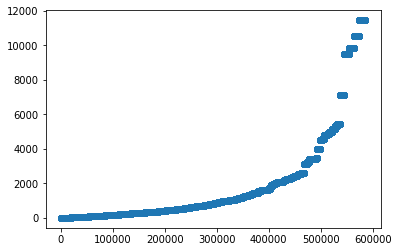

In [11]:
plt.scatter(range(len(data['o_appear_count'])),data['o_appear_count'].sort_values().values)

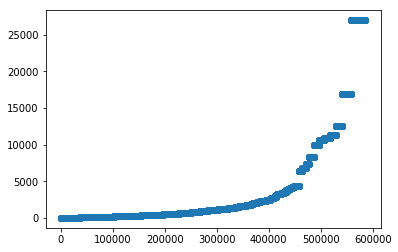

In [14]:
plt.scatter(range(len(data['d_appear_count'])),data['d_appear_count'].sort_values().values)

In [23]:
# data=data.drop(['o_count_label', 'd_count_label', 'o_count_label_mode_0_x',
#        'o_count_label_mode_1_x', 'o_count_label_mode_2_x',
#        'o_count_label_mode_3_x', 'o_count_label_mode_4_x',
#        'o_count_label_mode_5_x', 'o_count_label_mode_6_x',
#        'o_count_label_mode_7_x', 'o_count_label_mode_8_x',
#        'o_count_label_mode_9_x', 'o_count_label_mode_10_x',
#        'o_count_label_mode_11_x', 'd_count_label_mode_0',
#        'd_count_label_mode_1', 'd_count_label_mode_2',
#        'd_count_label_mode_3', 'd_count_label_mode_4',
#        'd_count_label_mode_5', 'd_count_label_mode_6',
#        'd_count_label_mode_7', 'd_count_label_mode_8',
#        'd_count_label_mode_9', 'd_count_label_mode_10',
#        'd_count_label_mode_11', 'o_count_label_mode_0_y',
#        'o_count_label_mode_1_y', 'o_count_label_mode_2_y',
#        'o_count_label_mode_3_y', 'o_count_label_mode_4_y',
#        'o_count_label_mode_5_y', 'o_count_label_mode_6_y',
#        'o_count_label_mode_7_y', 'o_count_label_mode_8_y',
#        'o_count_label_mode_9_y', 'o_count_label_mode_10_y',
#        'o_count_label_mode_11_y'],axis=1)
# data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

In [24]:
#对地点次数做分箱   分10个箱子    对起点进行分箱

bins = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]

res1 = pd.cut(data['o_appear_count'], bins, labels=["a","b","c","f","r","t","y","u","i","m","n","v"])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['o_count_label']=le.transform(res1)
data['o_count_label']

0         2
1         0
2         5
3         0
4         0
5         2
6         5
7         9
8         6
9         0
10        6
11        5
12        0
13        0
14        1
15        0
16        0
17        1
18        2
19        6
20        0
21        0
22        0
23        2
24        0
25        4
26        6
27        6
28        1
29        2
         ..
585903    2
585904    0
585905    0
585906    0
585907    0
585908    7
585909    0
585910    0
585911    1
585912    1
585913    2
585914    3
585915    1
585916    0
585917    2
585918    1
585919    0
585920    1
585921    2
585922    0
585923    0
585924    2
585925    0
585926    0
585927    0
585928    1
585929    0
585930    4
585931    0
585932    0
Name: o_count_label, Length: 585933, dtype: int32

In [25]:
#对终点进行分箱

bins = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,20000,40000]

res1 = pd.cut(data['d_appear_count'], bins, labels=["a","b","c","f","r","t","y","u","i","m","n","v","v1","v2","v3","v4","v5"])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['d_count_label']=le.transform(res1)
data['d_count_label']

0          5
1          0
2          0
3          1
4          0
5          1
6          0
7         11
8          1
9          0
10         1
11         5
12         0
13         0
14         3
15         0
16         0
17         1
18         1
19         5
20         0
21         0
22         1
23         1
24         0
25        10
26         8
27         5
28         2
29         0
          ..
585903     0
585904     1
585905     0
585906     0
585907     4
585908     6
585909     3
585910     1
585911     0
585912     0
585913    10
585914     2
585915     1
585916     0
585917    10
585918     1
585919     0
585920     0
585921     1
585922     0
585923     0
585924     0
585925     3
585926     0
585927     0
585928     1
585929     0
585930     0
585931     0
585932     1
Name: d_count_label, Length: 585933, dtype: int32

In [26]:
#三种根据label的统计方式
def add_statistics_o_conut_label(data, feat='pid'):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat]]
    feat_stat['feat_click_count'] = 1
    # the number
    feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
    feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    # print(feat_sum)
    # print(feat_stat[feat])
    # print(feat_mode_arr[:, -1])
    idx = 0
    for r_i, row in feat_stat.iterrows():
        # print(row)
        if int(row[feat]) != feat_sum[feat].values[idx]:
            # print('%d, %d, %d, %d' % (r_i, idx, int(row[feat]), feat_sum[feat].values[idx]))
            # if idx > 100:
            #     break
            idx += 1
        # the probability
        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]

    feat_mode = {}
    feat_mode[feat] = feat_sum[feat]
    for i in range(12):
        feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=feat, how='left')

    return data

data = add_statistics_o_conut_label(data, 'o_count_label')
data = add_statistics_o_conut_label(data, 'd_count_label')


adding statistics ...
adding statistics ...


In [27]:
def add_statistics_2(data, feat1, feat2):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat1, feat2]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat1, feat2]]
    feat_stat['feat_click_count'] = 1
    # the number
    feat_stat = feat_stat.groupby(['click_mode', feat1, feat2]).agg('sum').reset_index()
    feat_stat = feat_stat.sort_index(by=[feat1, feat2, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat1, feat2]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat1, feat2]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat1, feat2]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    idx = 0
    for r_i, row in tqdm(feat_stat.iterrows()):
        # print(row)
        if int(row[feat1]) != feat_sum[feat1].values[idx] or int(row[feat2]) != feat_sum[feat2].values[idx]:
            idx += 1
        # the probability

        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / (feat_sum['feat_sum'].values[idx]+1)
        
    feat_mode = {}
    feat_mode[feat1] = feat_sum[feat1]
    feat_mode[feat2] = feat_sum[feat2]    
    for i in range(12):
        feat_mode[feat1 + '_2_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=[feat1,feat2], how='left')

    return data

data = add_statistics_2(data, 'o_count_label','d_count_label')

adding statistics ...


1310it [00:00, 9102.27it/s]


In [ ]:
bins = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]

res1 = pd.cut(data['o_appear_count'], bins, labels=["a","b","c","f","r","t","y","u","i","m","n","v"])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['o_count_label']=le.transform(res1)


#对终点进行分箱

bins = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,20000,40000]

res1 = pd.cut(data['d_appear_count'], bins, labels=["a","b","c","f","r","t","y","u","i","m","n","v","v1","v2","v3","v4","v5"])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['d_count_label']=le.transform(res1)

#三种根据label的统计方式
def add_statistics_o_conut_label(data, feat='pid'):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat]]
    feat_stat['feat_click_count'] = 1
    # the number
    feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
    feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    # print(feat_sum)
    # print(feat_stat[feat])
    # print(feat_mode_arr[:, -1])
    idx = 0
    for r_i, row in feat_stat.iterrows():
        # print(row)
        if int(row[feat]) != feat_sum[feat].values[idx]:
            # print('%d, %d, %d, %d' % (r_i, idx, int(row[feat]), feat_sum[feat].values[idx]))
            # if idx > 100:
            #     break
            idx += 1
        # the probability
        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]

    feat_mode = {}
    feat_mode[feat] = feat_sum[feat]
    for i in range(12):
        feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=feat, how='left')

    return data

data = add_statistics_o_conut_label(data, 'o_count_label')
data = add_statistics_o_conut_label(data, 'd_count_label')



def add_statistics_2(data, feat1, feat2):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat1, feat2]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat1, feat2]]
    feat_stat['feat_click_count'] = 1
    # the number
    feat_stat = feat_stat.groupby(['click_mode', feat1, feat2]).agg('sum').reset_index()
    feat_stat = feat_stat.sort_index(by=[feat1, feat2, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat1, feat2]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat1, feat2]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat1, feat2]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    idx = 0
    for r_i, row in tqdm(feat_stat.iterrows()):
        # print(row)
        if int(row[feat1]) != feat_sum[feat1].values[idx] or int(row[feat2]) != feat_sum[feat2].values[idx]:
            idx += 1
        # the probability

        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / (feat_sum['feat_sum'].values[idx]+1)
        
    feat_mode = {}
    feat_mode[feat1] = feat_sum[feat1]
    feat_mode[feat2] = feat_sum[feat2]    
    for i in range(12):
        feat_mode[feat1 + '_2_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=[feat1,feat2], how='left')

    return data

data = add_statistics_2(data, 'o_count_label','d_count_label')

## 时间特征

#### 固定间隔上的转换率统计特征
效果比较好，在时间间隔上统计，而不是细的统计，极大的放置信息爆炸



In [4]:
#函数是共享的     是对不同情况下点击率情况的统计     这个人做的相当灵活，统计了在不同hour_minute_10下人的  mode转换率
def add_statistics(data, feat='pid'):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat]]
    feat_stat['feat_click_count'] = 1
    # the number
    feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
    feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    # print(feat_sum)
    # print(feat_stat[feat])
    # print(feat_mode_arr[:, -1])
    idx = 0
    for r_i, row in feat_stat.iterrows():
        # print(row)
        if int(row[feat]) != feat_sum[feat].values[idx]:
            # print('%d, %d, %d, %d' % (r_i, idx, int(row[feat]), feat_sum[feat].values[idx]))
            # if idx > 100:
            #     break
            idx += 1
        # the probability
        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]

    feat_mode = {}
    feat_mode[feat] = feat_sum[feat]
    for i in range(12):
        feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=feat, how='left')

    return data

#data['real_dis_100'] = data['real_dis'].apply(lambda x: x // 100)
# data = add_statistics(data, 'real_dis_100')
# data = add_statistics(data, 'week_hour_minute')
# data['week_hour_minute_10'] = ((data['weekday'] * 24 + data['hour']) * 60 + data['minute']) // 10
# data = add_statistics(data, 'week_hour_minute_10')
data['hour_minute_10'] = data['req_time_hour'] * 6 + data['req_time_minute'] // 10
data = add_statistics(data, 'hour_minute_10')

# data['hour_minute_30'] = data['req_time_hour'] * 2 + data['req_time_minute'] // 30
# data = add_statistics(data, 'hour_minute_30')

adding statistics ...


In [34]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

## 天气特征

In [ ]:
# #计算距离
# def minkowski_distance(x1, x2, y1, y2, p):
#     return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1.0 / p)    

# def calculate_direction(d_lon, d_lat):  
#     result = np.zeros(len(d_lon))   
#     l = np.sqrt(d_lon**2 + d_lat**2)
#     result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
#     idx = (d_lon<0) & (d_lat>0)
#     result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
#     idx = (d_lon<0) & (d_lat<0)
#     result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])   
#     return result

# def add_travel_vector_features(df):    
#     df['delta_longitude'] = df.o_lng - df.d_lng
#     df['delta_latitude'] = df.o_lat - df.d_lat   
#     df['pickup_x'] = np.cos(df.o_lat) * np.cos(df.o_lng)
#     df['pickup_y'] = np.cos(df.o_lat) * np.sin(df.o_lng)
#     df['pickup_z'] = np.sin(df.o_lat)   
#     df['dropoff_x'] = np.cos(df.d_lat) * np.cos(df.d_lng)
#     df['dropoff_y'] = np.cos(df.d_lat) * np.sin(df.d_lng)
#     df['dropoff_z'] = np.sin(df.d_lat)

# data['manhattan'] = minkowski_distance(data.o_lng, data.d_lng, 
#                                            data.o_lat, data.d_lat, 1)
# data['euclidean']=minkowski_distance(data.o_lng, data.d_lng, 
#                                            data.o_lat, data.d_lat, 2)

# add_travel_vector_features(data)
# data['direction'] = calculate_direction(data.delta_longitude, data.delta_latitude)

# distance_features = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']

# #加大学特征
# def school_(x):
#     if x*1609<1000:
#         return 1
#     else:
#         return 0

# list0 = list(np.load(path+'list.npy'))
# list0 = [x*1609 for x in list0]
# data["od_s"] = list0

# school_feature = ['od_s']

# #加公交站台特征
# def bus_o(x):
#     if x<400:
#         return 1
#     else:
#         return 0
    
# def bus_od(x):
#     if x<1000:
#         return 1
#     else:
#         return 0
    
# dist_bus1 = pd.read_csv( path+'dis2bus_test.csv')
# dist_bus2 = pd.read_csv(path+'dis2bus.csv')
# dist_bus  = pd.concat([dist_bus1, dist_bus2], ignore_index=True)
# data=data.merge(dist_bus, 'left', ['sid'])

# data['o_d_dis2bus'] = data['odis2bus']+data['ddis2bus']

# bus_feature = ['o_d_dis2bus','odis2bus','ddis2bus']

# #加地铁特征
# df1 = pd.read_csv( path+ 'dis2subway.csv')
# df2 = pd.read_csv( path+ 'dis2subway_test.csv',index_col=0)
# df  = pd.concat([df1, df2], ignore_index=0)
# data=data.merge(df, 'left', ['sid'])

# def subway_o(x):
#     if x<600:
#         return 1   
#     else:
#         return 0
    
# def subway_od(x):
#     if x<1000:
#         return 1   
#     else:
#         return 0

# data['o_d_dis2subway']=data['odis2subway']+data['ddis2subway']

# subway_feature = ['o_d_dis2subway','odis2subway','ddis2subway']
# #加天气特征

# #weather特征
# weather = pd.read_csv( path+'weather_clean.csv')
# weather.rename(columns={'req_time':'req_time_new'},inplace=True) 
# weather = weather[['req_time_new','temperature','dewPoint','humidity','humidity','windBearing','windSpeed']]  #weather中的时间是按1小时为时间段
# def tran_time(x):   #按照半小时为时间段处理原data中的click_time列
#     try:
#         if x.minute<30:
#             return (x+pd.Timedelta(minutes=-x.minute,seconds = -x.second))    #0~30分钟的按00分算
#         else:
#             return (x+pd.Timedelta(minutes=-x.minute,hours=1,seconds = -x.second)) #30~60分钟的加一小时
#     except:
#         return 0

# data['req_time_new'] = pd.to_datetime(data['req_time'])

# data['req_time_new'] = data['req_time_new'].apply(lambda x:tran_time(x))

# #将主key的类型保持一致，不然merge后的weather全为nan
# weather["req_time_new"] = weather["req_time_new"].apply(lambda x:str(x))
# data["req_time_new"] = data["req_time_new"].apply(lambda x:str(x))
# data  = data.merge(weather, 'left', ['req_time_new'])
# del data['req_time_new']

# weather_feature = ['temperature','dewPoint','humidity','humidity','windBearing','windSpeed']

## 用户属性特征

In [46]:
def rank(data, feat1, feat2, rank_name='rank', ascending=True):
    if type(feat1) == list: feat = feat1 + [feat2]
    else: feat = [feat1, feat2]
    use_feat = list(set(feat + ['sid', 'd']))
    datatmp = data[use_feat]
    datatmp.sort_values(feat, inplace=True, ascending=ascending)
    datatmp[rank_name] = range(datatmp.shape[0])
    min_rank = datatmp.groupby(feat1, as_index=False)[rank_name].agg({'min_rank': 'min'})
    datatmp = pd.merge(datatmp, min_rank, on=feat1, how='left')
    datatmp[rank_name] = datatmp[rank_name] - datatmp['min_rank']
    data = pd.merge(data, datatmp[['sid', 'd', rank_name]], on=['sid', 'd'], how='left')
    # del data['min_rank']
    return data

'''
	获取用户特征
'''
# 获取出发地到目的地的欧氏距离和曼哈顿距离
def get_distance(result):
    locs = list(set(result['o']) | set(result['d']))
    if np.nan in locs: 
        locs.remove(np.nan)
    deloc = []
    for loc in locs:
        deloc.append(loc)
    loc_dict = dict(zip(locs))
    geohashed_loc = result[['o', 'd']].values
    distance = []
    manhattan_distance = []
    for i in geohashed_loc:
        if i[0] is not np.nan and i[1] is not np.nan:
            lat1, lon1, _, _ = loc_dict[i[0]]
            lat2, lon2, _, _ = loc_dict[i[1]]
            distance.append(cal_distance(float(lat1), float(lon1), float(lat2), float(lon2)))
            manhattan_distance.append(manhattan(float(lat1), float(lon1), float(lat2), float(lon2)))
        else:
            distance.append(np.nan)
            manhattan_distance.append(np.nan)
    result.loc[:, 'od_manhattan_distance'] = distance
    result.loc[:, 'od_manhattan_distance_detail'] = manhattan_distance
    return result



# ----------------- 计数 -------------------

# 获取用户历史出行次数
def get_user_count(train, result):
    user_count = train.groupby('pid', as_index=False)['sid'].agg({'user_count': 'count'})
    result = pd.merge(result, user_count, on=['pid'], how='left')
    return result

# 获取用户去过某个地点的历史出行次数
def get_user_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['pid', 'd'], how='left')
    return result

# 获取用户从某个地方出发的历史出行次数
def get_user_sloc_count(train, result):
    user_sloc_count = train.groupby(['pid', 'o'], as_index=False)['pid'].agg({'user_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['pid', 'o'], how='left')
    return result

# 获取用户从某个地方出发到某个地方结束的历史出行次数
def get_user_sloc_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_eloc_count = train.groupby(['pid', 'o', 'd'], as_index=False)['pid'].agg({'user_sloc_eloc_count': 'count'})
    result = pd.merge(result, user_sloc_eloc_count, on=['pid', 'o', 'd'], how='left')
    return result

# 获取用户从某个目的地出发到某个出发地结束的历史返程次数
def get_user_eloc_sloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_sloc_count = train.groupby(['pid', 'o', 'd'], as_index=False)['pid'].agg({'user_eloc_sloc_count': 'count'})
    user_eloc_sloc_count.rename(columns={'o':'d', 'd':'o'}, inplace=True)
    result = pd.merge(result, user_eloc_sloc_count, on=['pid', 'o', 'd'], how='left')
    return result

# 获取用户的返程比例
def get_user_eloc_sloc_rate(train, result):
    train = train[~train.d.isnull()]
    user_eloc_sloc_count = train.groupby(['pid', 'o', 'd'], as_index=False)['pid'].agg({'user_eloc_sloc_count': 'count'})
    user_eloc_sloc_count.rename(columns={'o':'d', 'd':'o'}, inplace=True)
    restmp = pd.merge(train, user_eloc_sloc_count, on=['pid', 'o', 'd'], how='left')
    restmp = restmp.groupby('pid', as_index=False)['user_eloc_sloc_count'].agg({'user_eloc_sloc_rate': lambda x: np.sum(x>0)/np.size(x)})
    result = pd.merge(result, restmp, on='pid', how='left')
    return result

# 获取用户目的地点作为出发地的次数
def get_user_eloc_as_sloc_count(train, result):
    user_eloc_as_sloc_count = train.groupby(['pid', 'o'], as_index=False)['pid'].agg({'user_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['pid', 'd'], how='left')
    return result

# 获取用户出发地点作为目的地的次数
def get_user_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_as_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['pid', 'o'], how='left')
    return result

# 获取用户目的地出现在出发地中的个数
def get_user_eloc_in_sloc_count(result):
    user_eloc_in_sloc_count = result.groupby(['pid', 'o'], as_index=False)['sid'].agg({'user_eloc_in_sloc_count': lambda x: np.unique(x).size})
    user_eloc_in_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_in_sloc_count, on=['pid', 'd'], how='left')
    return result

# 获取用户涉及到的地点个数
def get_user_loccount(train, result):
    user_sloc = train[['pid', 'o']]
    train = train[~train.d.isnull()]
    user_eloc = train[['pid', 'd']].rename(columns={'d': 'o'}, inplace=True)
    user_loc = pd.concat([user_sloc, user_eloc])
    user_loccount = user_loc.groupby('pid', as_index=False)['o'].agg({'user_loccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_loccount, on=['pid'], how='left')
    return result

# 获取用户出发的出发地个数
def get_user_sloccount(train, result):
    user_sloccount = train.groupby('pid', as_index=False)['o'].agg({'user_sloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_sloccount, on=['pid'], how='left')
    return result

# 获取用户到达的目的地个数
def get_user_eloccount(train, result):
    train = train[~train.d.isnull()]
    user_eloccount = train.groupby('pid', as_index=False)['d'].agg({'user_eloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_eloccount, on=['pid'], how='left')
    return result

# 获取用户从某个地方出发到的目的地数目
def get_user_sloc_eloccount(train, result):
    train = train[~train.d.isnull()]
    user_sloc_eloccount = train.groupby(['pid', 'o'], as_index=False)['d'].agg({'user_sloc_eloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_sloc_eloccount, on=['pid', 'o'], how='left')
    return result

# 获取用户到某个地方结束的出发地数目
def get_user_eloc_sloccount(train, result):
    train = train[~train.d.isnull()]
    user_eloc_sloccount = train.groupby(['pid', 'd'], as_index=False)['o'].agg({'user_eloc_sloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_eloc_sloccount, on=['pid', 'd'], how='left')
    return result

# 获取用户在每个小时段的出行订单数
def get_user_hour_count(train, result):
    user_hour_count = train.groupby(['pid', 'req_time_hour'], as_index=False)['pid'].agg({'user_hour_count': 'count'})
    result = pd.merge(result, user_hour_count, on=['pid', 'req_time_hour'], how='left')
    return result

# 获取用户在每个小时段从某个地方出发的订单数
def get_user_sloc_hour_count(train, result):
    user_sloc_hour_count = train.groupby(['pid', 'o', 'req_time_hour'], as_index=False)['sid'].agg({'user_sloc_hour_count': 'count'})
    result = pd.merge(result, user_sloc_hour_count, on=['pid', 'o', 'req_time_hour'], how='left')
    return result

# 获取用户在每个小时段到某个地方结束的订单数
def get_user_eloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_hour_count = train.groupby(['pid', 'd', 'req_time_hour'], as_index=False)['sid'].agg({'user_eloc_hour_count': 'count'})
    result = pd.merge(result, user_eloc_hour_count, on=['pid', 'd', 'req_time_hour'], how='left')
    return result

# 获取用户在每个小时段从某个地方出发到某个地方结束的订单数
def get_user_sloc_eloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_eloc_hour_count = train.groupby(['pid', 'o', 'd', 'req_time_hour'], as_index=False)['sid'].agg({'user_sloc_eloc_hour_count': 'count'})
    result = pd.merge(result, user_sloc_eloc_hour_count, on=['pid', 'o', 'd', 'req_time_hour'], how='left')
    return result

# 获取用户在每个小时段从某个地方出发到某个地方结束的返程订单数
def get_user_eloc_sloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_sloc_hour_count = train.groupby(['pid', 'o', 'd', 'req_time_hour'], as_index=False)['sid'].agg({'user_eloc_sloc_hour_count': 'count'})
    user_eloc_sloc_hour_count.rename(columns={'o': 'd', 'd': 'o'}, inplace=True)
    result = pd.merge(result, user_eloc_sloc_hour_count, on=['pid', 'o', 'd', 'req_time_hour'], how='left') # 1
    return result

# 获取用户每个小时段涉及到的地点数
def get_user_hour_loccount(train, result):
    user_hour_sloc = train[['pid', 'req_time_hour', 'o']]
    train = train[~train.d.isnull()]
    user_hour_eloc = train[['pid', 'req_time_hour', 'd']].rename(columns={'d': 'o'}, inplace=True)
    user_hour_loc = pd.concat([user_hour_sloc, user_hour_eloc])
    user_hour_loccount = user_hour_loc.groupby(['pid', 'req_time_hour'], as_index=False)['o'].agg({'user_hour_loccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_hour_loccount, on=['pid', 'req_time_hour'], how='left')
    return result

# 获取用户每个小时段出发的出发地个数
def get_user_hour_sloccount(train, result):
    user_hour_sloccount = train.groupby(['pid', 'req_time_hour'], as_index=False)['o'].agg({'user_hour_sloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_hour_sloccount, on=['pid', 'req_time_hour'], how='left') # 4
    return result

# 获取用户每个小时段到达的目的地个数
def get_user_hour_eloccount(train, result):
    train = train[~train.d.isnull()]
    user_hour_eloccount = train.groupby(['pid', 'req_time_hour'], as_index=False)['d'].agg({'user_hour_eloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_hour_eloccount, on=['pid', 'req_time_hour'], how='left')
    return result

# 获取用户每个小时段从某个地方出发到的目的地数目
def get_user_sloc_hour_eloccount(train, result):
    train = train[~train.d.isnull()]
    user_sloc_hour_eloccount = train.groupby(['pid', 'o', 'req_time_hour'], as_index=False)['d'].agg({'user_sloc_hour_eloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_sloc_hour_eloccount, on=['pid', 'o', 'req_time_hour'], how='left')
    return result

# 获取用户每个小时段到某个地方结束的出发地数目
def get_user_eloc_hour_sloccount(train, result):
    train = train[~train.d.isnull()]
    user_eloc_hour_sloccount = train.groupby(['pid', 'd', 'req_time_hour'], as_index=False)['o'].agg({'user_eloc_hour_sloccount': lambda x: np.unique(x).size})
    result = pd.merge(result, user_eloc_hour_sloccount, on=['pid', 'd', 'req_time_hour'], how='left') # 9
    return result

# ----------------- 统计 -------------------

# 获取用户出行距离的统计值
def get_user_distance_stat(train, result):
    train = train[~train.d.isnull()]
    user_distance_stat = train.groupby('pid', as_index=False)['od_manhattan_distance'].agg({'user_distance_max': 'max', 'user_distance_min': 'min', 'user_distance_mean': 'mean'})
    result = pd.merge(result, user_distance_stat, on=['pid'], how='left')
    user_manhattan_stat = train.groupby('pid', as_index=False)['od_manhattan_distance_detail'].agg({'user_manhattan_max': 'max', 'user_manhattan_min': 'min', 'user_manhattan_mean': 'mean'})
    result = pd.merge(result, user_manhattan_stat, on=['pid'], how='left')
    return result

# 获取用户出行距离的分位点
def get_user_distance_quantile(train, result):
    train = train[~train.d.isnull()]
    user_distance_quantile = train.groupby('pid')['od_manhattan_distance'].quantile(0.2).reset_index()
    user_distance_quantile.rename(columns={'od_manhattan_distance': 'user_distance_quantile_2'}, inplace=True)
    result = pd.merge(result, user_distance_quantile, on='pid', how='left')
    
    user_manhattan_quantile = train.groupby('pid')['od_manhattan_distance_detail'].quantile(0.2).reset_index()
    user_manhattan_quantile.rename(columns={'od_manhattan_distance_detail': 'user_manhattan_quantile_2'}, inplace=True)
    result = pd.merge(result, user_manhattan_quantile, on='pid', how='left')
    
    user_distance_quantile = train.groupby('pid')['od_manhattan_distance'].quantile(0.8).reset_index()
    user_distance_quantile.rename(columns={'od_manhattan_distance': 'user_distance_quantile_8'}, inplace=True)
    result = pd.merge(result, user_distance_quantile, on='pid', how='left')
    return result

# 获取用户从某个地点出发的出行距离统计值
def get_user_sloc_distance_stat(train, result):
    train = train[~train.d.isnull()]
    user_sloc_distance_stat = train.groupby(['pid', 'o'], as_index=False)['od_manhattan_distance'].agg({'user_sloc_distance_max': 'max', 'user_sloc_distance_min': 'min', 'user_sloc_distance_mean': 'mean'})
    result = pd.merge(result, user_sloc_distance_stat, on=['pid', 'o'], how='left')
    user_sloc_manhattan_stat = train.groupby(['pid', 'o'], as_index=False)['od_manhattan_distance_detail'].agg({'user_sloc_manhattan_max': 'max', 'user_sloc_manhattan_min': 'min', 'user_sloc_manhattan_mean': 'mean'})
    result = pd.merge(result, user_sloc_manhattan_stat, on=['pid', 'o'], how='left')
    return result

# 获取用户到某个地点结束的出行距离统计值
def get_user_eloc_distance_stat(train, result):
    train = train[~train.d.isnull()]
    user_eloc_distance_stat = train.groupby(['pid', 'd'], as_index=False)['od_manhattan_distance'].agg({'user_eloc_distance_max': 'max', 'user_eloc_distance_min': 'min', 'user_eloc_distance_mean': 'mean'})
    result = pd.merge(result, user_eloc_distance_stat, on=['pid', 'd'], how='left')
    return result

# 获取用户各时间段出行距离的统计值
def get_user_hour_distance_stat(train, result):
    train = train[~train.d.isnull()]
    user_hour_distance_stat = train.groupby(['pid', 'req_time_hour'], as_index=False)['od_manhattan_distance'].agg({'user_hour_distance_max': 'max', 'user_hour_distance_min': 'min', 'user_hour_distance_mean': 'mean'})
    result = pd.merge(result, user_hour_distance_stat, on=['pid', 'req_time_hour'], how='left')
    user_hour_manhattan_stat = train.groupby(['pid', 'req_time_hour'], as_index=False)['od_manhattan_distance_detail'].agg({'user_hour_manhattan_max': 'max', 'user_hour_manhattan_min': 'min', 'user_hour_manhattan_mean': 'mean'})
    result = pd.merge(result, user_hour_manhattan_stat, on=['pid', 'req_time_hour'], how='left')
    return result

# 获取用户各时间段从某个地点出发的出行距离统计值
def get_user_sloc_hour_distance_stat(train, result):
    train = train[~train.d.isnull()]
    user_sloc_hour_distance_stat = train.groupby(['pid', 'o', 'req_time_hour'], as_index=False)['od_manhattan_distance'].agg({'user_sloc_hour_distance_max': 'max', 'user_sloc_hour_distance_min': 'min', 'user_sloc_hour_distance_mean': 'mean'})
    result = pd.merge(result, user_sloc_hour_distance_stat, on=['pid', 'o', 'req_time_hour'], how='left')
    user_sloc_hour_manhattan_stat = train.groupby(['pid', 'o', 'req_time_hour'], as_index=False)['od_manhattan_distance_detail'].agg({'user_sloc_hour_manhattan_max': 'max', 'user_sloc_hour_manhattan_min': 'min', 'user_sloc_hour_manhattan_mean': 'mean'})
    result = pd.merge(result, user_sloc_hour_manhattan_stat, on=['pid', 'o', 'req_time_hour'], how='left')
    return result

# 获取用户各时间段到某个地点结束的出行距离统计值
def get_user_eloc_hour_distance_stat(train, result):
    train = train[~train.d.isnull()]
    user_eloc_hour_distance_stat = train.groupby(['pid', 'd', 'req_time_hour'], as_index=False)['od_manhattan_distance'].agg({'user_eloc_hour_distance_max': 'max', 'user_eloc_hour_distance_min': 'min', 'user_eloc_hour_distance_mean': 'mean'})
    result = pd.merge(result, user_eloc_hour_distance_stat, on=['pid', 'd', 'req_time_hour'], how='left')
    return result

# 获取用户出行的小时段统计值
def get_user_hour_stat(train, result):
    user_hour_stat = train.groupby(['pid'], as_index=False)['req_time_hour'].agg({'user_hour_max': 'max', 'user_hour_min': 'min', 'user_hour_mean': 'mean'})
    result = pd.merge(result, user_hour_stat, on=['pid'], how='left')
    return result

# 获取用户从某个地点出行的小时段统计值
def get_user_sloc_hour_stat(train, result):
    user_sloc_hour_stat = train.groupby(['pid', 'o'], as_index=False)['req_time_hour'].agg({'user_sloc_hour_max': 'max', 'user_sloc_hour_min': 'min', 'user_sloc_hour_mean': 'mean'})
    result = pd.merge(result, user_sloc_hour_stat, on=['pid', 'o'], how='left')
    return result

# 获取用户到某个地点结束的小时段统计值
def get_user_eloc_hour_stat(train, result):
    train = train[~train.d.isnull()]
    user_eloc_hour_stat = train.groupby(['pid', 'd'], as_index=False)['req_time_hour'].agg({'user_eloc_hour_max': 'max', 'user_eloc_hour_min': 'min', 'user_eloc_hour_mean': 'mean'})
    result = pd.merge(result, user_eloc_hour_stat, on=['pid', 'd'], how='left')
    return result

# 获取用户从某个地点出发到某个地点结束的小时段统计值
def get_user_sloc_eloc_hour_stat(train, result):
    train = train[~train.d.isnull()]
    user_sloc_eloc_hour_stat = train.groupby(['pid', 'o', 'd'], as_index=False)['req_time_hour'].agg({'user_sloc_eloc_hour_max': 'max', 'user_sloc_eloc_hour_min': 'min', 'user_sloc_eloc_hour_mean': 'mean'}) # 6
    # user_sloc_eloc_hour_stat = train.groupby(['userid', 'geohashed_start_loc', 'geohashed_end_loc'], as_index=False)['hour'].agg({'user_sloc_eloc_hour_min': 'min', 'user_sloc_eloc_hour_mean': 'mean'})
    result = pd.merge(result, user_sloc_eloc_hour_stat, on=['pid', 'o', 'd'], how='left')
    return result

# 获取用户到过最多的地点的各信息
def get_user_most_freq_eloc(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_eloc_count': 'count'})
    user_most_freq_eloc = user_eloc_count.sort_values(by=['pid', 'user_eloc_count']).groupby('pid', as_index=False).last()[['pid', 'd']]
    user_most_freq_eloc.rename(columns={'d': 'user_most_freq_eloc'}, inplace=True)
    result = pd.merge(result, user_most_freq_eloc, on='pid', how='left')
    restmp = result[['sid', 'o', 'user_most_freq_eloc']];
    restmp.rename(columns={'user_most_freq_eloc': 'd'}, inplace=True)
    restmp = get_distance(restmp)
    restmp = get_sloc_latlon(restmp)
    restmp = pd.merge(restmp, get_eloc_latlon(restmp[~restmp.d.isnull()][['sid', 'd']]), on=['sid', 'd'], how='left')
    restmp = get_eloc_sloc_latlon_sub(restmp)
    restmp = get_eloc_sloc_slope(restmp)
    restmp = get_eloc_sloc_latlon_sub_divide_distance(restmp)
    restmp = get_bearing_array(restmp)
    result['user_most_freq_eloc_distance'] = restmp['od_manhattan_distance']
    result['user_most_freq_eloc_distance_sub'] = result['od_manhattan_distance'] - result['user_most_freq_eloc_distance']
    result['user_most_freq_eloc_distance_sub_abs'] = (result['od_manhattan_distance'] - result['user_most_freq_eloc_distance']).abs()
    result['user_most_freq_eloc_manhattan_distance'] = restmp['od_manhattan_distance_detail']
    result['user_most_freq_eloc_manhattan_sub'] = result['od_manhattan_distance_detail'] - result['user_most_freq_eloc_manhattan_distance']
    result['user_most_freq_eloc_manhattan_sub_abs'] = (result['od_manhattan_distance_detail'] - result['user_most_freq_eloc_manhattan_distance']).abs()
    result['user_most_freq_eloc_lon_sub'] = restmp['eloc_sloc_lon_sub']
    result['user_most_freq_eloc_lat_sub'] = restmp['eloc_sloc_lat_sub']
    result['user_most_freq_eloc_slope'] = restmp['eloc_sloc_latlon_slope']
    result['user_most_freq_eloc_lat_sub_divide_distance'] = restmp['eloc_sloc_lat_sub_divide_distance']
    result['user_most_freq_eloc_lon_sub_divide_distance'] = restmp['eloc_sloc_lon_sub_divide_distance']
    result.drop(['user_most_freq_eloc'], axis=1, inplace=True)
    return result

# 获取用户到某个地点的最后一次时间与当前的时间差
# def get_user_eloc_lasttime(train, result):
#     train = train[~train.geohashed_end_loc.isnull()]
#     train = train.sort_values(by='starttime')
#     user_eloc_last = train.groupby(['userid','geohashed_end_loc'], as_index=False).last()[['userid','geohashed_end_loc', 'starttime']]
#     user_eloc_last.rename(columns={'starttime': 'user_eloc_lasttime'}, inplace=True)
#     result = pd.merge(result, user_eloc_last, on=['userid', 'geohashed_end_loc'], how='left')
#     result['user_eloc_lasttime'] = (pd.DatetimeIndex(result.starttime) - pd.DatetimeIndex(result.user_eloc_lasttime)).total_seconds().values
#     return result

# ----------------- 排序 -------------------

# 获取用户到某个地点结束的距离排序
def get_user_eloc_distance_rank(result):
    result = rank(result, ['pid', 'd'], 'od_manhattan_distance', rank_name='user_eloc_distance_rank', ascending=False)
    return result

# 获取用户从某个地点出发的距离排序
def get_user_sloc_distance_rank(result):
    result = rank(result, ['pid', 'o'], 'od_manhattan_distance', rank_name='user_sloc_distance_rank', ascending=False)
    return result

# 获取用户各小时段到某个地点结束的距离排序
def get_user_eloc_hour_distance_rank(result):
    result = rank(result, ['pid', 'o', 'req_time_hour'], 'od_manhattan_distance', rank_name='user_eloc_hour_distance_rank', ascending=False)
    return result

# 获取用户各小时段从某个地点出发的距离排序
def get_user_sloc_hour_distance_rank(result):
    result = rank(result, ['pid', 'd', 'req_time_hour'], 'od_manhattan_distance', rank_name='user_sloc_hour_distance_rank', ascending=False)
    return result

# 获取用户出行时间的小时段排序
def get_user_hour_rank(result):
    result = rank(result, 'pid', 'req_time_hour', rank_name='user_hour_rank', ascending=False)
    return result

# 获取用户从某个地点出发的出行时间的小时段排序
def get_user_sloc_hour_rank(result):
    result = rank(result, ['pid', 'o'], 'req_time_hour', rank_name='user_sloc_hour_rank', ascending=False)
    return result

# 获取用户到某个地点结束的出行时间的小时段排序
def get_user_eloc_hour_rank(result):
    result = rank(result, ['pid', 'd'], 'req_time_hour', rank_name='user_eloc_hour_rank', ascending=False)
    return result

# 获取用户从某个地点出发到某个地点结束的出行时间的小时段排序
def get_user_sloc_eloc_hour_rank(result):
    result = rank(result, ['pid', 'o', 'd'], 'req_time_hour', rank_name='user_sloc_eloc_hour_rank', ascending=False) # 5
    return result

# ----------------- 差值 -------------------

# 获取实际距离与用户出行距离统计值的(绝对)差值
def get_user_distance_stat_sub(result):
    result['user_distance_mean_sub'] = (result['od_manhattan_distance'] - result['user_distance_mean'])
    result['user_distance_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_distance_mean']).abs()
    result['user_manhattan_mean_sub'] = (result['od_manhattan_distance_detail'] - result['user_manhattan_mean'])
    result['user_manhattan_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['user_manhattan_mean']).abs()
    return result

# 获取实际距离与用户从某个点出发距离统计值的(绝对)差值
def get_user_sloc_distance_stat_sub(result):
    result['user_sloc_distance_mean_sub'] = (result['od_manhattan_distance'] - result['user_sloc_distance_mean'])
    result['user_sloc_distance_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_sloc_distance_mean']).abs()
    result['user_sloc_manhattan_mean_sub'] = (result['od_manhattan_distance_detail'] - result['user_sloc_manhattan_mean'])
    result['user_sloc_manhattan_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['user_sloc_manhattan_mean']).abs()
    return result

# 获取实际距离与用户到某个点结束距离统计值的(绝对)差值
def get_user_eloc_distance_stat_sub(result):
    result['user_eloc_distance_mean_sub'] = (result['od_manhattan_distance'] - result['user_eloc_distance_mean'])
    result['user_eloc_distance_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_eloc_distance_mean']).abs()
    return result

# 获取实际距离与用户出行距离统计值的各小时段(绝对)差值
def get_user_hour_distance_stat_sub(result):
    result['user_hour_distance_mean_sub'] = (result['od_manhattan_distance'] - result['user_hour_distance_mean'])
    result['user_hour_distance_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_hour_distance_mean']).abs()
    result['user_hour_manhattan_mean_sub'] = (result['od_manhattan_distance_detail'] - result['user_hour_manhattan_mean'])
    result['user_hour_manhattan_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['user_hour_manhattan_mean']).abs()
    return result

# 获取实际距离与用户从某个点出发距离统计值的各小时段(绝对)差值
def get_user_sloc_hour_distance_stat_sub(result):
    result['user_sloc_hour_distance_mean_sub'] = (result['od_manhattan_distance'] - result['user_sloc_hour_distance_mean'])
    result['user_sloc_hour_distance_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_sloc_hour_distance_mean']).abs()
    result['user_sloc_hour_manhattan_mean_sub'] = (result['od_manhattan_distance_detail'] - result['user_sloc_hour_manhattan_mean'])
    result['user_sloc_hour_manhattan_mean_sub_abs'] = (result['od_manhattan_distance_detail'] - result['user_sloc_hour_manhattan_mean']).abs()
    return result

# 获取实际距离与用户到某个点结束距离统计值的各小时段(绝对)差值
def get_user_eloc_hour_distance_stat_sub(result):
    result['user_eloc_hour_distance_mean_sub'] = (result['od_manhattan_distance'] - result['user_eloc_hour_distance_mean'])
    result['user_eloc_hour_distance_mean_sub_abs'] = (result['od_manhattan_distance'] - result['user_eloc_hour_distance_mean']).abs()
    return result

# 获取小时段与用户出行的小时段统计值的(绝对)差值
def get_hour_user_hour_stat_sub(result):
    result['hour_user_hour_mean_sub'] = (result['req_time_hour'] - result['user_hour_mean'])
    result['hour_user_hour_mean_sub_abs'] = (result['req_time_hour'] - result['user_hour_mean']).abs()
    return result

# 获取小时段与用户从某个地方出发的小时段统计值的(绝对)差值
def get_hour_user_sloc_hour_stat_sub(result):
    result['hour_user_sloc_hour_mean_sub'] = (result['req_time_hour'] - result['user_sloc_hour_mean'])
    result['hour_user_sloc_hour_mean_sub_abs'] = (result['req_time_hour'] - result['user_sloc_hour_mean']).abs()
    return result

# 获取小时段与用户到某个地方结束的小时段统计值的(绝对)差值
def get_hour_user_eloc_hour_stat_sub(result):
    result['hour_user_eloc_hour_mean_sub'] = (result['req_time_hour'] - result['user_eloc_hour_mean'])
    result['hour_user_eloc_hour_mean_sub_abs'] = (result['req_time_hour'] - result['user_eloc_hour_mean']).abs()
    return result

# 获取小时段与用户从某个地点出发到某个地方结束的小时段统计值的(绝对)差值
def get_hour_user_sloc_eloc_hour_stat_sub(result):
    result['hour_user_sloc_eloc_hour_mean_sub'] = (result['req_time_hour'] - result['user_sloc_eloc_hour_mean'])
    result['hour_user_sloc_eloc_hour_mean_sub_abs'] = (result['req_time_hour'] - result['user_sloc_eloc_hour_mean']).abs()
    return result

# 获取用户到某个目的地的个数占用户出行总数的比例
def get_user_eloc_count_ratio(result):
    result['user_eloc_count_ratio'] = result['user_eloc_count_x'] / result['user_count']
    return result


In [47]:


data=get_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_sloc_rate(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_in_sloc_count(data)
data=get_user_loccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_eloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=data=get_user_eloc_sloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)

data=get_user_sloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_eloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_sloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_loccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_sloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_eloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_hour_eloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_hour_sloccount(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_distance_quantile(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_hour_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_hour_distance_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_hour_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_hour_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_eloc_hour_stat(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)

data=get_user_eloc_distance_rank(data)
data=get_user_sloc_distance_rank(data)
data=get_user_eloc_hour_distance_rank(data)
data=get_user_sloc_hour_distance_rank(data)
data=get_user_hour_rank(data)
data=get_user_sloc_hour_rank(data)
data=get_user_eloc_hour_rank(data)
data=get_user_sloc_distance_stat_sub(data)
data=get_user_eloc_distance_stat_sub(data)

data=get_user_hour_distance_stat_sub(data)
data=get_user_sloc_hour_distance_stat_sub(data)
data=get_user_eloc_hour_distance_stat_sub(data)
data=get_hour_user_hour_stat_sub(data)
data=get_hour_user_sloc_hour_stat_sub(data)
data=get_hour_user_eloc_hour_stat_sub(data)
data=get_hour_user_sloc_eloc_hour_stat_sub(data)

data=get_user_eloc_count_ratio(data)

In [92]:
#有些问题
#data=get_user_most_freq_eloc(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)

In [93]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

### pid转换统计特征
把profiles表做TruncatedSVD，有没有尝试过把1替换成对应的p，然后0替换为na后删去，最后来做tf-idf


In [19]:
print('------  构建针对profile的主成分特征。   ------')

profiles=pd.read_csv('../data/data_set_phase2/profiles.csv')
columns=list(profiles.columns.values)

def gen_user_nlp(data):
    pid_text_list=[]
    for i, person in profiles.iterrows():
        pid_text=''
 
        for i in range(1,67):
            if person[i]==1:
                pid_text=pid_text+'_'+columns[i]
        pid_text_list.append(pid_text)   
    
    print('user_nlp tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(pid_text_list)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    per_svd = svd_enc.fit_transform(tfidf_vec)
    per_svd = pd.DataFrame(per_svd)
    per_svd.columns = ['profile_tf_svd_{}'.format(i) for i in range(10)]
    per_svd['pid']=profiles['pid'].values
    
    
    data = data.merge(per_svd, on='pid', how='left')
    #data = pd.concat([data, per_svd], axis=1)
    return data

data=gen_user_nlp(data)

------  构建针对profile的主成分特征。   ------
user_nlp tfidf...


## 规则特征

In [34]:
def get_user_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['pid', 'd'], how='left')
    return result

def get_eloc_user_count(train, result):
    train = train[~train.d.isnull()]
    eloc_user_count = train.groupby(['d'], as_index=False)['pid'].agg({'eloc_user_count': lambda x: np.unique(x).size})
    result = pd.merge(result, eloc_user_count, on='d', how='left')
    return result

def get_user_hour_count(train, result):
    user_hour_count = train.groupby(['pid', 'req_time_hour'], as_index=False)['sid'].agg({'user_hour_count': 'count'})
    result = pd.merge(result, user_hour_count, on=['pid', 'req_time_hour'], how='left')
    return result


# 获取用户在每个小时段到某个地方结束的订单数
def get_user_eloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_hour_count = train.groupby(['pid', 'd', 'req_time_hour'], as_index=False)['sid'].agg({'user_eloc_hour_count': 'count'})
    result = pd.merge(result, user_eloc_hour_count, on=['pid', 'd', 'req_time_hour'], how='left')
    return result

# 获取目的地的热度
def get_eloc_count(train, result):
    train = train[~train.d.isnull()]
    eloc_count = train.groupby('d', as_index=False)['pid'].agg({'eloc_count': 'count'})
    result = pd.merge(result, eloc_count, on='d', how='left')
    return result

# 获取每个小时段的出行订单数
def get_hour_count(train, result):
    hour_count = train.groupby(['req_time_hour'], as_index=False)['pid'].agg({'hour_count': 'count'})
    result = pd.merge(result, hour_count, on='req_time_hour', how='left')
    return result

# 获取目的地在各小时段的订单数
def get_eloc_hour_count(train, result):
    train = train[~train.d.isnull()]
    eloc_hour_count = train.groupby(['d', 'req_time_hour'], as_index=False)['sid'].agg({'eloc_hour_count': 'count'})
    result = pd.merge(result, eloc_hour_count, on=['d', 'req_time_hour'], how='left')
    return result

data=get_user_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_user_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_hour_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
######################     上面为下面服务     ###################



def get_user_rule(result):
    result['user_rule'] = (1 + result['user_eloc_count']) * result['eloc_user_count'] / (0.01 * result['od_manhattan_distance'])
    return result

def get_user_didi(train, result):
    result['user_hour_count_rate'] = result['user_hour_count'] / train.shape[0]
    #train = train[~train.d.isnull()]
    result['user_eloc_count_rate'] = result['user_eloc_count'] / train.shape[0]
    result['user_hour_eloc_rate'] = result['user_eloc_hour_count'] / result['user_eloc_count']
    result['user_hour_eloc_distribute'] = result['user_eloc_count_rate'] * result['user_hour_eloc_rate'] / result['user_hour_count_rate']
    return result

def get_loc_rule(result):
    result['loc_rule'] = result['eloc_count'] / (0.01 * result['od_manhattan_distance_detail'])
    result['loc_rule2'] = np.sqrt(result['od_manhattan_distance_detail'] / (result['eloc_count'] ** 1.1))
    return result

def get_loc_didi(train, result):
    result['hour_count_rate'] = result['hour_count'] / train.shape[0]
    #train = train[~train.d.isnull()]
    result['eloc_count_rate'] = result['eloc_count'] / train.shape[0]
    result['hour_eloc_rate'] = result['eloc_hour_count'] / result['eloc_count']
    result['hour_eloc_distribute'] = result['eloc_count_rate'] * result['hour_eloc_rate'] / result['hour_count_rate']
    return result

data=get_user_rule(data)
data=get_user_didi(data[['user_hour_count','user_eloc_count']],data)
data=get_loc_rule(data)
data=get_loc_didi(data[['hour_count','eloc_count','eloc_hour_count']],data)


## leak特征

In [ ]:
# 获取出发地热度
def get_sloc_count(train, result):
    sloc_count = train.groupby('o', as_index=False)['pid'].agg({'sloc_count': 'count'})
    result = pd.merge(result, sloc_count, on='o', how='left')
    return result

# 获取目的地作为出发地的热度
def get_eloc_as_sloc_count(train, result):
    eloc_as_sloc_count = train.groupby('o', as_index=False)['pid'].agg({'eloc_as_sloc_count': 'count'})
    eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, eloc_as_sloc_count, on='d', how='left')
    return result
# 获取出发地作为目的地的热度
def get_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    sloc_as_eloc_count = train.groupby('d', as_index=False)['pid'].agg({'sloc_as_eloc_count': 'count'})
    sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, sloc_as_eloc_count, on='o', how='left')
    return result
# 获取目的地的热度
def get_eloc_count(train, result):
    train = train[~train.d.isnull()]
    eloc_count = train.groupby('d', as_index=False)['sid'].agg({'eloc_count': 'count'})
    result = pd.merge(result, eloc_count, on='d', how='left')
    return result
# 获取用户目的地点作为出发地的次数
def get_user_eloc_as_sloc_count(train, result):
    user_eloc_as_sloc_count = train.groupby(['pid', 'o'], as_index=False)['pid'].agg({'user_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['pid', 'd'], how='left')
    return result
# 获取用户出发地点作为目的地的次数
def get_user_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_as_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['pid', 'o'], how='left')
    return result
def get_user_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['pid', 'd'], how='left')
    return result
# 获取用户从某个地方出发的历史出行次数
def get_user_sloc_count(train, result):
    user_sloc_count = train.groupby(['pid', 'o'], as_index=False)['pid'].agg({'user_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['pid', 'o'], how='left')
    return result

data=get_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)

## 协同过滤特征

In [4]:
# 获取出发地热度
def get_sloc_count(train, result):
    sloc_count = train.groupby('o', as_index=False)['pid'].agg({'sloc_count': 'count'})
    result = pd.merge(result, sloc_count, on='o', how='left')
    return result

# 获取目的地作为出发地的热度
def get_eloc_as_sloc_count(train, result):
    eloc_as_sloc_count = train.groupby('o', as_index=False)['pid'].agg({'eloc_as_sloc_count': 'count'})
    eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, eloc_as_sloc_count, on='d', how='left')
    return result
# 获取出发地作为目的地的热度
def get_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    sloc_as_eloc_count = train.groupby('d', as_index=False)['pid'].agg({'sloc_as_eloc_count': 'count'})
    sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, sloc_as_eloc_count, on='o', how='left')
    return result
# 获取目的地的热度
def get_eloc_count(train, result):
    train = train[~train.d.isnull()]
    eloc_count = train.groupby('d', as_index=False)['sid'].agg({'eloc_count': 'count'})
    result = pd.merge(result, eloc_count, on='d', how='left')
    return result
# 获取用户目的地点作为出发地的次数
def get_user_eloc_as_sloc_count(train, result):
    user_eloc_as_sloc_count = train.groupby(['pid', 'o'], as_index=False)['pid'].agg({'user_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['pid', 'd'], how='left')
    return result
# 获取用户出发地点作为目的地的次数
def get_user_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_as_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['pid', 'o'], how='left')
    return result
def get_user_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['pid', 'd'], as_index=False)['pid'].agg({'user_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['pid', 'd'], how='left')
    return result
# 获取用户从某个地方出发的历史出行次数
def get_user_sloc_count(train, result):
    user_sloc_count = train.groupby(['pid', 'o'], as_index=False)['pid'].agg({'user_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['pid', 'o'], how='left')
    return result


data=get_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)

In [10]:
##############################################   准备的特征   ##########################
# 获取地址对的协同过滤信息
def get_loc_filter(train, result):
    sloc_elocs, eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['o', 'd']].values):
        if i[0] not in sloc_elocs:
            sloc_elocs[i[0]] = {}
        if i[1] not in sloc_elocs[i[0]]:
            sloc_elocs[i[0]][i[1]] = 0
        sloc_elocs[i[0]][i[1]] += 1
        if i[1] not in eloc_slocs:
            eloc_slocs[i[1]] = {}
        if i[0] not in eloc_slocs[i[1]]:
            eloc_slocs[i[1]][i[0]] = 0;
        eloc_slocs[i[1]][i[0]] += 1
    sloc_list, eloc_list, sloc_eloc_common_eloc_count, sloc_eloc_common_sloc_count, sloc_eloc_common_conn1_count, sloc_eloc_common_conn2_count = [], [], [], [], [], []
    for i in tqdm.tqdm(result[['o', 'd']].drop_duplicates().values):
        sloc_list.append(i[0])
        eloc_list.append(i[1])
        # 获取地址对在历史记录中共有的目的地数目
        common_eloc_count = 0
        if (i[0] in sloc_elocs) and (i[1] in sloc_elocs):
            sloc_eloc_common_eloc_set = sloc_elocs[i[0]].keys() & sloc_elocs[i[1]].keys()
            for common_eloc in sloc_eloc_common_eloc_set:
                print('common_eloc :',len(common_eloc))
                common_eloc_count = common_eloc_count + sloc_elocs[i[0]][common_eloc] + sloc_elocs[i[1]][common_eloc]
        sloc_eloc_common_eloc_count.append(common_eloc_count)
        # 获取地址对在历史记录中共有的出发地数目
        common_sloc_count = 0
        if (i[0] in eloc_slocs) and (i[1] in eloc_slocs):
            sloc_eloc_common_sloc_set = eloc_slocs[i[0]].keys() & eloc_slocs[i[1]].keys()
            for common_sloc in sloc_eloc_common_sloc_set:
                common_sloc_count = common_sloc_count + eloc_slocs[i[0]][common_sloc] + eloc_slocs[i[1]][common_sloc]
        sloc_eloc_common_sloc_count.append(common_sloc_count)
        # 获取地址对在历史记录中共有的连接点数目(出发点->xx->目的地)
        common_conn1_count = 0
        if (i[0] in sloc_elocs) and (i[1] in eloc_slocs):
            sloc_eloc_common_conn1_set = sloc_elocs[i[0]].keys() & eloc_slocs[i[1]].keys()
            for common_conn1 in sloc_eloc_common_conn1_set:
                common_conn1_count = common_conn1_count + sloc_elocs[i[0]][common_conn1] + eloc_slocs[i[1]][common_conn1]
        sloc_eloc_common_conn1_count.append(common_conn1_count)
        # 获取地址对在历史记录中共有的连接点数目(出发点<-xx<-目的地)
        common_conn2_count = 0
        if (i[0] in eloc_slocs) and (i[1] in sloc_elocs):
            sloc_eloc_common_conn2_set = eloc_slocs[i[0]].keys() & sloc_elocs[i[1]].keys()
            for common_conn2 in sloc_eloc_common_conn2_set:
                common_conn2_count = common_conn2_count + eloc_slocs[i[0]][common_conn2] + sloc_elocs[i[1]][common_conn2]
        sloc_eloc_common_conn2_count.append(common_conn2_count)
    loc_filter = pd.DataFrame({"o": sloc_list, "d": eloc_list, "sloc_eloc_common_eloc_count": sloc_eloc_common_eloc_count, "sloc_eloc_common_sloc_count": sloc_eloc_common_sloc_count, "sloc_eloc_common_conn1_count": sloc_eloc_common_conn1_count, "sloc_eloc_common_conn2_count": sloc_eloc_common_conn2_count})
    result = pd.merge(result, loc_filter, on=['o', 'd'], how='left')
    result['sloc_eloc_common_eloc_rate'] = result['sloc_eloc_common_eloc_count']/(result['sloc_count']+result['eloc_as_sloc_count'])
    result['sloc_eloc_common_sloc_rate'] = result['sloc_eloc_common_sloc_count']/(result['sloc_as_eloc_count']+result['eloc_count'])
    result['sloc_eloc_common_conn1_rate'] = result['sloc_eloc_common_conn1_count']/(result['sloc_count']+result['eloc_count'])
    result['sloc_eloc_common_conn2_rate'] = result['sloc_eloc_common_conn2_count']/(result['sloc_as_eloc_count']+result['eloc_as_sloc_count'])
    return result

# 获取用户地址对的协同过滤信息
def get_user_loc_filter(train, result):
    user_sloc_elocs, user_eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['pid', 'o', 'd']].values):
        if i[0] not in user_sloc_elocs:
            user_sloc_elocs[i[0]] = {}
        if i[1] not in user_sloc_elocs[i[0]]:
            user_sloc_elocs[i[0]][i[1]] = {}
        if i[2] not in user_sloc_elocs[i[0]][i[1]]:
            user_sloc_elocs[i[0]][i[1]][i[2]] = 0
        user_sloc_elocs[i[0]][i[1]][i[2]] += 1
        if i[0] not in user_eloc_slocs:
            user_eloc_slocs[i[0]] = {}
        if i[2] not in user_eloc_slocs[i[0]]:
            user_eloc_slocs[i[0]][i[2]] = {};
        if i[1] not in user_eloc_slocs[i[0]][i[2]]:
            user_eloc_slocs[i[0]][i[2]][i[1]] = 0
        user_eloc_slocs[i[0]][i[2]][i[1]] += 1
    user_list, user_sloc_list, user_eloc_list, user_sloc_eloc_common_eloc_count, user_sloc_eloc_common_sloc_count, user_sloc_eloc_common_conn1_count, user_sloc_eloc_common_conn2_count = [], [], [], [], [], [], []
    for i in tqdm.tqdm(result[['pid', 'o', 'd']].drop_duplicates().values):
        user_list.append(i[0])
        user_sloc_list.append(i[1])
        user_eloc_list.append(i[2])
        # 获取地址对在用户历史记录中共有的目的地数目
        user_common_eloc_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_eloc_set = user_sloc_elocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_eloc in user_sloc_eloc_common_eloc_set:
                user_common_eloc_count = user_common_eloc_count + user_sloc_elocs[i[0]][i[1]][user_common_eloc] + user_sloc_elocs[i[0]][i[2]][user_common_eloc]
        user_sloc_eloc_common_eloc_count.append(user_common_eloc_count)
        # 获取地址对在用户历史记录中共有的出发地数目
        user_common_sloc_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_sloc_set = user_eloc_slocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_sloc in user_sloc_eloc_common_sloc_set:
                user_common_sloc_count = user_common_sloc_count + user_eloc_slocs[i[0]][i[1]][user_common_sloc] + user_eloc_slocs[i[0]][i[2]][user_common_sloc]
        user_sloc_eloc_common_sloc_count.append(user_common_sloc_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点->xx->目的地)
        user_common_conn1_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[0] in user_eloc_slocs) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_conn1_set = user_sloc_elocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_conn1 in user_sloc_eloc_common_conn1_set:
                user_common_conn1_count = user_common_conn1_count + user_sloc_elocs[i[0]][i[1]][user_common_conn1] + user_eloc_slocs[i[0]][i[2]][user_common_conn1]
        user_sloc_eloc_common_conn1_count.append(user_common_conn1_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点<-xx<-目的地)
        user_common_conn2_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[0] in user_sloc_elocs) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_conn2_set = user_eloc_slocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_conn2 in user_sloc_eloc_common_conn2_set:
                user_common_conn2_count = user_common_conn2_count + user_eloc_slocs[i[0]][i[1]][user_common_conn2] + user_sloc_elocs[i[0]][i[2]][user_common_conn2]
        user_sloc_eloc_common_conn2_count.append(user_common_conn2_count)
    user_loc_filter = pd.DataFrame({"pid": user_list, "o": user_sloc_list, "d": user_eloc_list, "user_sloc_eloc_common_eloc_count": user_sloc_eloc_common_eloc_count, "user_sloc_eloc_common_sloc_count": user_sloc_eloc_common_sloc_count, "user_sloc_eloc_common_conn1_count": user_sloc_eloc_common_conn1_count, "user_sloc_eloc_common_conn2_count": user_sloc_eloc_common_conn2_count})
    result = pd.merge(result, user_loc_filter, on=['pid', 'o', 'd'], how='left')
    result['user_sloc_eloc_common_eloc_rate'] = result['user_sloc_eloc_common_eloc_count']/(result['user_sloc_count']+result['user_eloc_as_sloc_count'])
    result['user_sloc_eloc_common_sloc_rate'] = result['user_sloc_eloc_common_sloc_count']/(result['user_sloc_as_eloc_count']+result['user_eloc_count'])
    result['user_sloc_eloc_common_conn1_rate'] = result['user_sloc_eloc_common_conn1_count']/(result['user_sloc_count']+result['user_eloc_count'])
    result['user_sloc_eloc_common_conn2_rate'] = result['user_sloc_eloc_common_conn2_count']/(result['user_sloc_as_eloc_count']+result['user_eloc_as_sloc_count'])
    return result

data=get_loc_filter(data[['pid','o','d']],data)
data=get_user_loc_filter(data[['pid','o','d']],data)



  0%|                                                                                       | 0/585933 [00:00<?, ?it/s]

  7%|████▊                                                                  | 40016/585933 [00:00<00:01, 399136.44it/s]

 13%|█████████▌                                                             | 78741/585933 [00:00<00:01, 395141.69it/s]

 20%|██████████████▏                                                       | 118509/585933 [00:00<00:01, 395621.57it/s]

 27%|██████████████████▋                                                   | 156805/585933 [00:00<00:01, 391415.42it/s]

 34%|███████████████████████▋                                              | 198178/585933 [00:00<00:00, 397495.12it/s]

 40%|████████████████████████████▏                                         | 236438/585933 [00:00<00:00, 392639.27it/s]

 47%|████████████████████████████████▉                                     | 275914/585933 [00:00<00:00, 392906.16it/s]

 54%|█████████████████████████

sloc_elocs 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




i[0] 121.51,31.23
sloc_elocs[i[0]] {'121.50,31.24': 80, '121.49,31.23': 49, '121.59,31.26': 10, '121.51,31.23': 287, '121.55,31.20': 6, '121.18,31.03': 1, '121.52,31.23': 97, '121.60,31.12': 1, '121.66,31.30': 1, '121.43,31.37': 2, '121.56,31.15': 2, '121.55,30.85': 1, '121.47,31.24': 27, '121.55,31.24': 7, '121.59,31.27': 1, '121.45,31.22': 17, '121.48,31.24': 47, '121.61,31.31': 1, '121.51,31.16': 3, '121.68,31.22': 3, '121.53,31.24': 7, '121.80,31.15': 47, '121.32,31.20': 76, '121.27,31.09': 1, '121.45,31.25': 44, '121.55,31.29': 3, '121.41,31.14': 2, '121.39,31.16': 3, '121.41,31.12': 1, '121.48,31.25': 18, '121.18,31.37': 1, '121.68,31.27': 4, '121.60,31.24': 1, '121.52,31.24': 18, '121.94,30.90': 1, '121.42,31.17': 2, '121.53,31.31': 3, '121.56,31.23': 5, '121.56,31.21': 17, '121.52,31.21': 22, '121.58,31.25': 3, '121.44,31.23': 7, '121.52,31.22': 19, '121.42,31.20': 1, '121.59,31.25': 1, '121.49,31.19': 6, '121.46,31.21': 40, '121.40,31.14': 3, '121.35,31.15': 8, '121.50,31.17'

sloc_elocs[i[0]].keys : dict_keys(['121.50,31.24', '121.49,31.23', '121.59,31.26', '121.51,31.23', '121.55,31.20', '121.18,31.03', '121.52,31.23', '121.60,31.12', '121.66,31.30', '121.43,31.37', '121.56,31.15', '121.55,30.85', '121.47,31.24', '121.55,31.24', '121.59,31.27', '121.45,31.22', '121.48,31.24', '121.61,31.31', '121.51,31.16', '121.68,31.22', '121.53,31.24', '121.80,31.15', '121.32,31.20', '121.27,31.09', '121.45,31.25', '121.55,31.29', '121.41,31.14', '121.39,31.16', '121.41,31.12', '121.48,31.25', '121.18,31.37', '121.68,31.27', '121.60,31.24', '121.52,31.24', '121.94,30.90', '121.42,31.17', '121.53,31.31', '121.56,31.23', '121.56,31.21', '121.52,31.21', '121.58,31.25', '121.44,31.23', '121.52,31.22', '121.42,31.20', '121.59,31.25', '121.49,31.19', '121.46,31.21', '121.40,31.14', '121.35,31.15', '121.50,31.17', '121.51,30.97', '121.24,31.09', '121.59,31.03', '121.45,31.20', '121.58,31.26', '121.27,31.39', '121.49,31.22', '121.36,31.14', '121.66,31.14', '121.49,31.24', '121.


sloc_elocs[i[1]].keys : dict_keys(['121.48,31.32', '121.47,31.25', '121.50,31.24', '121.49,31.24', '121.80,31.15', '121.49,31.23', '121.47,31.24', '121.41,31.11', '121.48,31.30', '121.53,31.27', '121.45,31.22', '121.67,31.15', '121.16,31.29', '121.51,31.24', '121.46,31.23', '121.32,31.20', '121.45,31.25', '121.72,31.06', '121.50,31.30', '121.50,31.22', '121.47,31.22', '121.54,31.22', '121.51,31.26', '121.54,31.28', '121.71,31.16', '121.48,31.24', '121.49,31.25', '121.36,31.19', '121.60,31.20', '121.43,31.27', '121.22,31.16', '121.32,31.30', '121.52,31.24', '121.51,31.21', '121.33,31.25', '121.51,31.25', '121.42,31.28', '121.26,31.12', '121.45,31.23', '121.51,31.23', '121.33,31.22', '121.36,31.25', '121.46,31.25', '121.44,31.23', '121.49,31.18', '121.43,31.20', '121.40,31.17', '121.48,31.23', '121.56,31.22', '121.55,31.24', '121.46,31.17', '121.55,31.21', '121.42,31.23', '121.41,31.13', '121.47,31.23', '121.53,31.32', '121.41,31.22', '121.41,31.17', '121.42,31.35', '121.66,31.14', '121

sloc_eloc_common_eloc_set: {'121.58,31.27', '121.72,31.24', '121.45,31.03', '121.48,31.20', '121.25,31.04', '121.37,31.17', '121.45,31.24', '121.50,31.17', '121.72,31.06', '121.59,31.27', '121.41,31.17', '121.35,31.18', '121.41,31.24', '121.55,31.18', '121.50,31.28', '121.57,31.26', '121.44,31.30', '121.52,31.24', '121.37,31.11', '121.48,31.22', '121.41,31.29', '121.61,31.21', '121.78,31.18', '121.56,31.14', '121.40,31.18', '121.45,31.20', '121.50,31.19', '121.58,31.26', '121.50,31.29', '121.33,31.24', '121.48,31.17', '121.49,31.14', '121.49,31.19', '121.53,31.23', '121.47,31.25', '121.59,31.26', '121.40,31.22', '121.39,31.32', '121.43,31.19', '121.53,31.19', '121.48,31.25', '121.83,31.49', '121.59,31.30', '121.52,31.19', '121.89,30.90', '121.22,31.38', '121.54,31.24', '121.43,31.23', '121.38,31.32', '121.54,31.21', '121.45,31.25', '121.46,31.24', '121.48,31.26', '121.48,31.29', '121.66,31.14', '121.44,31.21', '121.55,31.20', '121.48,31.24', '121.45,31.22', '121.52,31.23', '121.25,31.3



  0%|                                                                           | 1/239377 [00:01<109:18:23,  1.64s/it]

sloc_elocs 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




i[0] 121.32,31.30
sloc_elocs[i[0]] {'121.28,31.38': 2, '121.43,31.16': 4, '121.52,31.30': 1, '121.43,31.24': 2, '121.35,31.32': 7, '121.52,31.24': 2, '121.46,31.21': 13, '121.58,31.27': 1, '121.63,31.29': 2, '121.52,31.28': 1, '121.43,31.19': 1, '121.21,31.10': 3, '121.29,31.35': 1, '121.34,31.32': 4, '121.21,31.27': 1, '121.33,31.32': 7, '121.32,31.30': 37, '121.26,31.38': 1, '121.18,31.08': 1, '121.22,31.38': 2, '121.29,31.44': 1, '121.32,31.32': 3, '121.31,31.28': 4, '121.20,31.42': 2, '121.39,31.07': 1, '121.32,31.24': 5, '121.56,31.21': 3, '121.57,31.21': 1, '121.40,31.21': 2, '121.30,31.29': 34, '121.44,31.22': 4, '121.20,31.41': 3, '121.50,31.24': 11, '121.35,31.31': 1, '121.46,31.24': 1, '121.30,31.30': 13, '121.31,31.32': 2, '121.32,31.26': 2, '121.41,31.24': 8, '121.39,31.11': 1, '121.43,31.17': 3, '121.31,31.29': 22, '121.46,31.41': 2, '121.48,31.24': 9, '121.42,31.19': 1, '121.49,31.24': 11, '121.45,31.19': 4, '121.49,31.23': 10, '121.35,31.40': 1, '121.34,31.33': 2, '121.



  0%|                                                                            | 2/239377 [00:02<84:15:16,  1.27s/it]

sloc_elocs 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




i[0] 121.45,31.25
sloc_elocs[i[0]] {'121.45,31.27': 25, '121.36,31.28': 1, '121.80,31.15': 256, '121.51,31.23': 25, '121.44,31.17': 8, '121.63,31.14': 3, '121.46,31.25': 98, '121.45,31.20': 75, '121.45,31.23': 101, '121.34,30.79': 1, '121.45,31.29': 19, '121.45,31.25': 782, '121.40,31.13': 10, '121.45,31.24': 73, '121.47,31.16': 6, '121.35,31.40': 14, '121.61,31.31': 4, '121.32,31.20': 387, '121.50,31.24': 227, '121.51,31.16': 4, '121.05,31.11': 19, '121.45,31.26': 97, '121.69,30.87': 21, '121.47,31.32': 5, '121.36,31.14': 3, '121.42,31.16': 166, '121.28,31.22': 3, '121.44,31.14': 2, '121.48,31.23': 78, '121.47,31.23': 150, '121.60,31.13': 5, '121.54,31.21': 6, '121.49,31.23': 180, '121.40,31.08': 3, '121.40,31.23': 12, '121.43,31.29': 1, '121.46,31.21': 122, '121.65,31.03': 1, '121.81,31.15': 9, '121.41,31.24': 34, '121.66,31.14': 73, '121.55,31.24': 16, '121.62,31.20': 6, '121.48,31.24': 244, '121.60,31.30': 2, '121.53,31.23': 24, '121.43,31.05': 3, '121.23,31.39': 13, '121.37,31.28

sloc_elocs[i[0]].keys : dict_keys(['121.45,31.27', '121.36,31.28', '121.80,31.15', '121.51,31.23', '121.44,31.17', '121.63,31.14', '121.46,31.25', '121.45,31.20', '121.45,31.23', '121.34,30.79', '121.45,31.29', '121.45,31.25', '121.40,31.13', '121.45,31.24', '121.47,31.16', '121.35,31.40', '121.61,31.31', '121.32,31.20', '121.50,31.24', '121.51,31.16', '121.05,31.11', '121.45,31.26', '121.69,30.87', '121.47,31.32', '121.36,31.14', '121.42,31.16', '121.28,31.22', '121.44,31.14', '121.48,31.23', '121.47,31.23', '121.60,31.13', '121.54,31.21', '121.49,31.23', '121.40,31.08', '121.40,31.23', '121.43,31.29', '121.46,31.21', '121.65,31.03', '121.81,31.15', '121.41,31.24', '121.66,31.14', '121.55,31.24', '121.62,31.20', '121.48,31.24', '121.60,31.30', '121.53,31.23', '121.43,31.05', '121.23,31.39', '121.37,31.28', '121.41,31.22', '121.58,31.06', '121.49,31.18', '121.48,31.31', '121.48,31.30', '121.51,31.06', '121.43,31.16', '121.39,31.19', '121.39,31.25', '121.44,31.26', '121.47,31.25', '121.


sloc_elocs[i[1]].keys : dict_keys(['121.35,31.16', '121.43,31.28', '121.36,31.19', '121.33,31.17', '121.61,31.26', '121.45,31.27', '121.32,31.20', '121.44,31.22', '121.40,31.34', '121.39,31.21', '121.42,31.16', '121.36,31.17', '121.41,31.36', '121.43,31.24', '121.46,31.21', '121.45,31.25', '121.23,31.02', '121.48,31.23', '121.39,31.16', '121.49,31.23', '121.48,31.29', '121.47,31.24', '121.48,31.24', '121.23,31.06', '121.45,31.28', '121.59,31.21', '121.47,31.22', '121.47,31.27', '121.36,31.20', '121.33,31.24', '121.23,31.19', '121.50,31.29', '121.72,31.06', '121.54,31.22', '121.70,31.40', '121.37,31.23', '121.35,31.40', '121.49,31.24', '121.44,31.27', '121.44,31.40', '121.41,31.43', '121.47,31.25', '121.42,31.22', '121.47,31.23', '121.53,31.27', '121.48,31.26', '121.45,31.23', '121.40,31.14', '121.32,31.27', '121.51,31.15', '121.43,31.22', '121.42,31.38', '121.80,31.15', '121.47,31.21', '121.46,31.26', '121.30,31.19', '121.41,31.27', '121.59,31.34', '121.25,31.39', '121.47,31.26', '121

common_eloc : 12

KeyboardInterrupt: 

In [5]:
xietong_feature_shanghai=pd.read_csv('../feature_data/xietong_feature_shanghai.csv')
data=pd.concat((data,xietong_feature_shanghai),axis=1)

In [6]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

In [7]:
print('--------------    对原始的协同，做下变换扩展    -----------------')
# result['sloc_eloc_common_eloc_rate'] = result['sloc_eloc_common_eloc_count']/(result['sloc_count']+result['eloc_as_sloc_count'])
# result['sloc_eloc_common_sloc_rate'] = result['sloc_eloc_common_sloc_count']/(result['sloc_as_eloc_count']+result['eloc_count'])
# result['sloc_eloc_common_conn1_rate'] = result['sloc_eloc_common_conn1_count']/(result['sloc_count']+result['eloc_count'])
# result['sloc_eloc_common_conn2_rate'] = result['sloc_eloc_common_conn2_count']/(result['sloc_as_eloc_count']+result['eloc_as_sloc_count'])
# result['user_sloc_eloc_common_eloc_rate'] = result['user_sloc_eloc_common_eloc_count']/(result['user_sloc_count']+result['user_eloc_as_sloc_count'])
# result['user_sloc_eloc_common_sloc_rate'] = result['user_sloc_eloc_common_sloc_count']/(result['user_sloc_as_eloc_count']+result['user_eloc_count'])
# result['user_sloc_eloc_common_conn1_rate'] = result['user_sloc_eloc_common_conn1_count']/(result['user_sloc_count']+result['user_eloc_count'])
# result['user_sloc_eloc_common_conn2_rate'] = result['user_sloc_eloc_common_conn2_count']/(result['user_sloc_as_eloc_count']+result['user_eloc_as_sloc_count'])

#第一轮组合扩展，  有效
data['sloc_eloc_common_eloc_rate_1'] = data['sloc_eloc_common_eloc_count']/(data['sloc_as_eloc_count']+data['eloc_count'])
data['sloc_eloc_common_sloc_rate_1'] = data['sloc_eloc_common_sloc_count']/(data['sloc_count']+data['eloc_as_sloc_count'])
data['sloc_eloc_common_conn1_rate_1'] = data['sloc_eloc_common_conn1_count']/(data['sloc_as_eloc_count']+data['eloc_as_sloc_count'])
data['sloc_eloc_common_conn2_rate_1'] = data['sloc_eloc_common_conn2_count']/(data['sloc_count']+data['eloc_count'])
data['user_sloc_eloc_common_eloc_rate_1'] = data['user_sloc_eloc_common_eloc_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_count'])
data['user_sloc_eloc_common_sloc_rate_1'] = data['user_sloc_eloc_common_sloc_count']/(data['user_sloc_count']+data['user_eloc_as_sloc_count'])
data['user_sloc_eloc_common_conn1_rate_1'] = data['user_sloc_eloc_common_conn1_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_as_sloc_count'])
data['user_sloc_eloc_common_conn2_rate_1'] = data['user_sloc_eloc_common_conn2_count']/(data['user_sloc_count']+data['user_eloc_count'])


#进行第二波的构建    有效
data['sloc_eloc_common_eloc_rate_2'] = data['sloc_eloc_common_eloc_count']/(data['sloc_as_eloc_count']+data['eloc_as_sloc_count'])
data['sloc_eloc_common_sloc_rate_2'] = data['sloc_eloc_common_sloc_count']/(data['sloc_count']+data['eloc_count'])
data['sloc_eloc_common_conn1_rate_2'] = data['sloc_eloc_common_conn1_count']/(data['sloc_as_eloc_count']+data['eloc_count'])
data['sloc_eloc_common_conn2_rate_2'] = data['sloc_eloc_common_conn2_count']/(data['sloc_count']+data['eloc_as_sloc_count'])
data['user_sloc_eloc_common_eloc_rate_2'] = data['user_sloc_eloc_common_eloc_count']/(data['user_sloc_count']+data['user_eloc_count'])
data['user_sloc_eloc_common_sloc_rate_2'] = data['user_sloc_eloc_common_sloc_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_count'])
data['user_sloc_eloc_common_conn1_rate_2'] = data['user_sloc_eloc_common_conn1_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_as_sloc_count'])
data['user_sloc_eloc_common_conn2_rate_2'] = data['user_sloc_eloc_common_conn2_count']/(data['user_sloc_count']+data['user_eloc_as_sloc_count'])

# #进行第三波的构建   降分
# data['sloc_eloc_common_eloc_rate_3'] = data['sloc_eloc_common_eloc_count']/(data['sloc_count']+data['eloc_count'])
# data['sloc_eloc_common_sloc_rate_3'] = data['sloc_eloc_common_sloc_count']/(data['sloc_as_eloc_count']+data['eloc_as_sloc_count'])
# data['sloc_eloc_common_conn1_rate_3'] = data['sloc_eloc_common_conn1_count']/(data['sloc_count']+data['eloc_as_sloc_count'])
# data['sloc_eloc_common_conn2_rate_3'] = data['sloc_eloc_common_conn2_count']/(data['sloc_as_eloc_count']+data['eloc_count'])
# data['user_sloc_eloc_common_eloc_rate_3'] = data['user_sloc_eloc_common_eloc_count']/(data['user_sloc_count']+data['user_eloc_as_sloc_count'])
# data['user_sloc_eloc_common_sloc_rate_3'] = data['user_sloc_eloc_common_sloc_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_count'])
# data['user_sloc_eloc_common_conn1_rate_3'] = data['user_sloc_eloc_common_conn1_count']/(data['user_sloc_count']+data['user_eloc_count'])
# data['user_sloc_eloc_common_conn2_rate_3'] = data['user_sloc_eloc_common_conn2_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_as_sloc_count'])


--------------    对原始的协同，做下变换扩展    -----------------


In [126]:
#对两组有效的进行排序
# data['aa']=data['sloc_eloc_common_eloc_rate'].rank()
# data['bb']=data['sloc_eloc_common_sloc_rate'].rank()
# data['cc']=data['sloc_eloc_common_conn1_rate'].rank()
# data['dd']=data['sloc_eloc_common_conn2_rate'].rank()
# data['ee']=data['user_sloc_eloc_common_eloc_rate'].rank()
# data['ff']=data['user_sloc_eloc_common_sloc_rate'].rank()
# data['gg']=data['user_sloc_eloc_common_conn1_rate'].rank()
# data['hh']=data['user_sloc_eloc_common_conn2_rate'].rank()

data['a']=data['sloc_eloc_common_eloc_rate1'].rank()
data['d']=data['sloc_eloc_common_sloc_rate1'].rank()
data['v']=data['sloc_eloc_common_conn1_rate1'].rank()
data['f']=data['sloc_eloc_common_conn2_rate1'].rank()
data['c']=data['user_sloc_eloc_common_eloc_rate1'].rank()
data['x']=data['user_sloc_eloc_common_sloc_rate1'].rank()
data['w']=data['user_sloc_eloc_common_conn1_rate1'].rank()
data['h']=data['user_sloc_eloc_common_conn2_rate1'].rank()

data['aaa']=data['sloc_eloc_common_eloc_rate_2'].rank()
data['sdd']=data['sloc_eloc_common_sloc_rate_2'].rank()
data['sss']=data['sloc_eloc_common_conn1_rate_2'].rank()
data['vvv']=data['sloc_eloc_common_conn2_rate_2'].rank()
data['ccx']=data['user_sloc_eloc_common_eloc_rate_2'].rank()
data['zzz']=data['user_sloc_eloc_common_sloc_rate_2'].rank()
data['ttt']=data['user_sloc_eloc_common_conn1_rate_2'].rank()
data['uuu']=data['user_sloc_eloc_common_conn2_rate_2'].rank()



In [125]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

自己新增的协同特征
  
    （1）构建 req_time_hour、first_mode、   位置区域聚类
    （2）对后面比值的计算情况进行扩展(这个可以先跑出来再做比值，  很容易的)
    


对小时的协同挖掘

In [29]:
# 获取用户目的地点作为出发地的次数
def get_req_time_hour_eloc_as_sloc_count(train, result):
    user_eloc_as_sloc_count = train.groupby(['req_time_hour', 'o'], as_index=False)['pid'].agg({'req_time_hour_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['req_time_hour', 'd'], how='left')
    return result
# 获取用户出发地点作为目的地的次数
def get_req_time_hour_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_as_eloc_count = train.groupby(['req_time_hour', 'd'], as_index=False)['pid'].agg({'req_time_hour_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['req_time_hour', 'o'], how='left')
    return result
def get_req_time_hour_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['req_time_hour', 'd'], as_index=False)['pid'].agg({'req_time_hour_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['req_time_hour', 'd'], how='left')
    return result
# 获取用户从某个地方出发的历史出行次数
def get_req_time_hour_sloc_count(train, result):
    user_sloc_count = train.groupby(['req_time_hour', 'o'], as_index=False)['pid'].agg({'req_time_hour_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['req_time_hour', 'o'], how='left')
    return result
data=get_req_time_hour_eloc_as_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_req_time_hour_sloc_as_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_req_time_hour_eloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_req_time_hour_sloc_count(data[['o','d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)

In [30]:
# 获取小时 地址对的协同过滤信息
def get_req_time_hour_loc_filter(train, result):
    user_sloc_elocs, user_eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['req_time_hour', 'o', 'd']].values):
        if i[0] not in user_sloc_elocs:
            user_sloc_elocs[i[0]] = {}
        if i[1] not in user_sloc_elocs[i[0]]:
            user_sloc_elocs[i[0]][i[1]] = {}
        if i[2] not in user_sloc_elocs[i[0]][i[1]]:
            user_sloc_elocs[i[0]][i[1]][i[2]] = 0
        user_sloc_elocs[i[0]][i[1]][i[2]] += 1
        if i[0] not in user_eloc_slocs:
            user_eloc_slocs[i[0]] = {}
        if i[2] not in user_eloc_slocs[i[0]]:
            user_eloc_slocs[i[0]][i[2]] = {};
        if i[1] not in user_eloc_slocs[i[0]][i[2]]:
            user_eloc_slocs[i[0]][i[2]][i[1]] = 0
        user_eloc_slocs[i[0]][i[2]][i[1]] += 1
    user_list, user_sloc_list, user_eloc_list, user_sloc_eloc_common_eloc_count, user_sloc_eloc_common_sloc_count, user_sloc_eloc_common_conn1_count, user_sloc_eloc_common_conn2_count = [], [], [], [], [], [], []
    for i in tqdm.tqdm(result[['req_time_hour', 'o', 'd']].drop_duplicates().values):
        user_list.append(i[0])
        user_sloc_list.append(i[1])
        user_eloc_list.append(i[2])
        # 获取地址对在用户历史记录中共有的目的地数目
        user_common_eloc_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_eloc_set = user_sloc_elocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_eloc in user_sloc_eloc_common_eloc_set:
                user_common_eloc_count = user_common_eloc_count + user_sloc_elocs[i[0]][i[1]][user_common_eloc] + user_sloc_elocs[i[0]][i[2]][user_common_eloc]
        user_sloc_eloc_common_eloc_count.append(user_common_eloc_count)
        # 获取地址对在用户历史记录中共有的出发地数目
        user_common_sloc_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_sloc_set = user_eloc_slocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_sloc in user_sloc_eloc_common_sloc_set:
                user_common_sloc_count = user_common_sloc_count + user_eloc_slocs[i[0]][i[1]][user_common_sloc] + user_eloc_slocs[i[0]][i[2]][user_common_sloc]
        user_sloc_eloc_common_sloc_count.append(user_common_sloc_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点->xx->目的地)
        user_common_conn1_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[0] in user_eloc_slocs) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_conn1_set = user_sloc_elocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_conn1 in user_sloc_eloc_common_conn1_set:
                user_common_conn1_count = user_common_conn1_count + user_sloc_elocs[i[0]][i[1]][user_common_conn1] + user_eloc_slocs[i[0]][i[2]][user_common_conn1]
        user_sloc_eloc_common_conn1_count.append(user_common_conn1_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点<-xx<-目的地)
        user_common_conn2_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[0] in user_sloc_elocs) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_conn2_set = user_eloc_slocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_conn2 in user_sloc_eloc_common_conn2_set:
                user_common_conn2_count = user_common_conn2_count + user_eloc_slocs[i[0]][i[1]][user_common_conn2] + user_sloc_elocs[i[0]][i[2]][user_common_conn2]
        user_sloc_eloc_common_conn2_count.append(user_common_conn2_count)
    user_loc_filter = pd.DataFrame({"req_time_hour": user_list, "o": user_sloc_list, "d": user_eloc_list, "req_time_hour_sloc_eloc_common_eloc_count": user_sloc_eloc_common_eloc_count, "req_time_hour_sloc_eloc_common_sloc_count": user_sloc_eloc_common_sloc_count, "req_time_hour_sloc_eloc_common_conn1_count": user_sloc_eloc_common_conn1_count, "req_time_hour_sloc_eloc_common_conn2_count": user_sloc_eloc_common_conn2_count})
    result = pd.merge(result, user_loc_filter, on=['req_time_hour', 'o', 'd'], how='left')
    result['req_time_hour_sloc_eloc_common_eloc_rate'] = result['req_time_hour_sloc_eloc_common_eloc_count']/(result['req_time_hour_sloc_count']+result['req_time_hour_eloc_as_sloc_count'])
    result['req_time_hour_sloc_eloc_common_sloc_rate'] = result['req_time_hour_sloc_eloc_common_sloc_count']/(result['req_time_hour_eloc_count']+result['req_time_hour_sloc_as_eloc_count'])
    result['req_time_hour_sloc_eloc_common_conn1_rate'] = result['req_time_hour_sloc_eloc_common_conn1_count']/(result['req_time_hour_sloc_count']+result['req_time_hour_eloc_count'])
    result['req_time_hour_sloc_eloc_common_conn2_rate'] = result['req_time_hour_sloc_eloc_common_conn2_count']/(result['req_time_hour_sloc_as_eloc_count']+result['req_time_hour_eloc_as_sloc_count'])
    
    
    return result
data=get_req_time_hour_loc_filter(data[['req_time_hour','o','d']],data)




  0%|                                                                                       | 0/585933 [00:00<?, ?it/s]

  3%|██▍                                                                    | 19701/585933 [00:00<00:02, 196486.45it/s]

  8%|█████▍                                                                 | 44415/585933 [00:00<00:02, 209217.93it/s]

 12%|████████▍                                                              | 70034/585933 [00:00<00:02, 221242.19it/s]

 17%|███████████▊                                                           | 97784/585933 [00:00<00:02, 235410.16it/s]

 21%|███████████████                                                       | 125725/585933 [00:00<00:01, 246907.60it/s]

 26%|██████████████████▏                                                   | 152163/585933 [00:00<00:01, 251709.52it/s]

 30%|█████████████████████▎                                                | 178118/585933 [00:00<00:01, 253812.91it/s]

 34%|████████████████████████▏

 36%|█████████████████████████▎                                             | 151030/423600 [00:11<00:17, 15227.29it/s]

 36%|█████████████████████████▌                                             | 152600/423600 [00:11<00:17, 15354.01it/s]

 36%|█████████████████████████▊                                             | 154138/423600 [00:11<00:17, 15100.33it/s]

 37%|██████████████████████████                                             | 155651/423600 [00:11<00:17, 14895.87it/s]

 37%|██████████████████████████▎                                            | 157143/423600 [00:11<00:18, 14736.36it/s]

 37%|██████████████████████████▌                                            | 158629/423600 [00:11<00:17, 14761.55it/s]

 38%|██████████████████████████▊                                            | 160211/423600 [00:11<00:17, 15052.46it/s]

 38%|███████████████████████████                                            | 161833/423600 [00:11<00:17, 15371.19it/s]

 39%|███████████████████████████

 87%|█████████████████████████████████████████████████████████████▊         | 368489/423600 [00:25<00:03, 17561.68it/s]

 87%|██████████████████████████████████████████████████████████████         | 370254/423600 [00:25<00:03, 17574.10it/s]

 88%|██████████████████████████████████████████████████████████████▎        | 372016/423600 [00:25<00:03, 16963.05it/s]

 88%|██████████████████████████████████████████████████████████████▋        | 373763/423600 [00:25<00:02, 17098.66it/s]

 89%|██████████████████████████████████████████████████████████████▉        | 375506/423600 [00:25<00:02, 17183.13it/s]

 89%|███████████████████████████████████████████████████████████████▏       | 377229/423600 [00:25<00:02, 16610.40it/s]

 89%|███████████████████████████████████████████████████████████████▌       | 378909/423600 [00:25<00:02, 16653.64it/s]

 90%|███████████████████████████████████████████████████████████████▊       | 380752/423600 [00:25<00:02, 17136.79it/s]

 90%|███████████████████████████

KeyError: 'req_time_hour_sloc_eloc_common_eloc_count'

In [67]:
data

,Unnamed: 0,click_mode,click_time,d,o,pid,plan_time,plans,req_time,sid,...,plan_model_10_price_rank_guiyi,plan_model_10_rank_rank_guiyi,plan_model_11_dist_rank,plan_model_11_eta_rank,plan_model_11_price_rank,plan_model_11_rank_rank,plan_model_11_dist_rank_guiyi,plan_model_11_eta_rank_guiyi,plan_model_11_price_rank_guiyi,plan_model_11_rank_rank_guiyi
0,500002,2.0,2018-10-06 22:15:31,"121.50,31.24","121.51,31.23",NaN,2018-10-06 22:14:36,"[{""distance"": 2243, ""price"": 300, ""eta"": 1027,...",2018-10-06 22:14:36,702620,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
1,500008,1.0,2018-10-07 17:38:05,"121.28,31.38","121.32,31.30",57906.0,2018-10-07 17:38:02,"[{""distance"": 15372, ""price"": 200, ""eta"": 3359...",2018-10-07 17:38:02,640184,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
2,500010,0.0,NaN,"121.45,31.27","121.45,31.25",46141.0,NaN,NaN,2018-11-16 03:41:29,525250,...,0.015155,0.423612,34931.0,34931.0,34931.0,1091211.5,0.015155,0.015155,0.015155,0.473428
3,500011,7.0,2018-10-05 22:21:52,"121.51,31.31","121.28,31.35",NaN,2018-10-05 22:21:42,"[{""distance"": 26344, ""price"": """", ""eta"": 1734,...",2018-10-05 22:21:42,730057,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
4,500014,6.0,2018-10-23 20:10:31,"121.25,31.40","121.24,31.40",6197.0,2018-10-23 20:10:28,"[{""distance"": 708, ""price"": """", ""eta"": 656, ""t...",2018-10-23 20:10:28,790201,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
5,500019,2.0,2018-11-13 12:01:44,"121.47,31.20","121.45,31.20",107598.0,2018-11-13 12:01:38,"[{""distance"": 4854, ""price"": 300, ""eta"": 2230,...",2018-11-13 12:01:38,918191,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
6,500020,2.0,2018-10-13 06:59:55,"121.36,31.28","121.45,31.25",22024.0,2018-10-13 06:59:51,"[{""distance"": 13236, ""price"": 400, ""eta"": 2467...",2018-10-13 06:59:51,750735,...,0.105486,0.952352,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
7,500023,2.0,2018-11-02 14:25:27,"121.32,31.20","121.48,31.24",NaN,2018-11-02 14:25:19,"[{""distance"": 19431, ""price"": 500, ""eta"": 2386...",2018-11-02 14:25:19,628200,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
8,500024,2.0,2018-10-07 14:53:21,"121.55,31.23","121.52,31.23",24995.0,2018-10-07 14:53:19,"[{""distance"": 4448, ""price"": 300, ""eta"": 1453,...",2018-10-07 14:53:19,834074,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428
9,500026,1.0,2018-11-16 14:09:55,"121.26,31.03","121.23,31.02",16342.0,2018-11-16 14:09:53,"[{""distance"": 3500, ""price"": 100, ""eta"": 1412,...",2018-11-16 14:09:53,755990,...,NaN,0.423612,NaN,NaN,NaN,1091211.5,NaN,NaN,NaN,0.473428


对 地点聚类情况的协同挖掘     先起点聚类、后终点聚类

In [81]:
from sklearn.cluster import KMeans
def cluster_features(data):
    coords = np.vstack((data[['o_lng', 'o_lat']].values,
                        data[['d_lng', 'd_lat']].values))
    kmeans = KMeans(n_clusters=13).fit(coords)

    data.loc[:, 'o_kmeans'] = kmeans.predict(data[['o_lng', 'o_lat']])
    data.loc[:, 'd_kmeans'] = kmeans.predict(data[['d_lng', 'd_lat']])
    return data
data = cluster_features(data)

In [61]:
# 获取出发地热度
def get_sloc_count(train, result):
    sloc_count = train.groupby('o', as_index=False)['pid'].agg({'sloc_count': 'count'})
    result = pd.merge(result, sloc_count, on='o', how='left')
    return result

# 获取目的地作为出发地的热度
def get_eloc_as_sloc_count(train, result):
    eloc_as_sloc_count = train.groupby('o', as_index=False)['pid'].agg({'eloc_as_sloc_count': 'count'})
    eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, eloc_as_sloc_count, on='d', how='left')
    return result

In [77]:
data['d_kmeans']

0          9
1         12
2          9
3          5
4         12
5          9
6          4
7          4
8          6
9          2
10         9
11         8
12         5
13         4
14         9
15         6
16         6
17         5
18         9
19         9
20        10
21         3
22         1
23         8
24         9
25         9
26         9
27         9
28         1
29         8
          ..
585903     1
585904     1
585905     6
585906     9
585907     9
585908     9
585909     9
585910     4
585911    11
585912     9
585913     9
585914     9
585915     1
585916     6
585917     9
585918     1
585919     6
585920     1
585921     5
585922     2
585923     9
585924    11
585925     1
585926     1
585927     3
585928     9
585929    12
585930     5
585931    11
585932     1
Name: d_kmeans, Length: 585933, dtype: int32

In [ ]:
# 获取用户目的地点作为出发地的次数
def get_o_kmeans_eloc_as_sloc_count(train,result):
    user_eloc_as_sloc_count = train.groupby(['o_kmeans', 'o'], as_index=False)['sid'].agg({'o_kmeans_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['o_kmeans', 'd'], how='left')
    return result
# 获取用户出发地点作为目的地的次数
def get_o_kmeans_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_as_eloc_count = train.groupby(['o_kmeans', 'd'], as_index=False)['sid'].agg({'o_kmeans_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['o_kmeans', 'o'], how='left')
    return result
def get_o_kmeans_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['o_kmeans', 'd'], as_index=False)['sid'].agg({'o_kmeans_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['o_kmeans', 'd'], how='left')
    return result
# 获取用户从某个地方出发的历史出行次数
def get_o_kmeans_sloc_count(train, result):
    user_sloc_count = train.groupby(['o_kmeans', 'o'], as_index=False)['sid'].agg({'o_kmeans_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['o_kmeans', 'o'], how='left')
    return result
data=get_o_kmeans_eloc_as_sloc_count(data[['o','d','sid','pid','o_kmeans','d_kmeans']], data)
data=get_o_kmeans_sloc_as_eloc_count(data[['o','d','sid','pid','o_kmeans','d_kmeans']], data)
data=get_o_kmeans_eloc_count(data[['o','d','sid','pid','o_kmeans','d_kmeans']], data)
data=get_o_kmeans_sloc_count(data[['o','d','sid','pid','o_kmeans','d_kmeans']], data)


In [85]:



# 获取小时 地址对的协同过滤信息
def get_o_kmeans_loc_filter(train, result):
    user_sloc_elocs, user_eloc_slocs = {}, {}
    for i in tqdm(train[['o_kmeans', 'o', 'd']].values):
        if i[0] not in user_sloc_elocs:
            user_sloc_elocs[i[0]] = {}
        if i[1] not in user_sloc_elocs[i[0]]:
            user_sloc_elocs[i[0]][i[1]] = {}
        if i[2] not in user_sloc_elocs[i[0]][i[1]]:
            user_sloc_elocs[i[0]][i[1]][i[2]] = 0
        user_sloc_elocs[i[0]][i[1]][i[2]] += 1
        if i[0] not in user_eloc_slocs:
            user_eloc_slocs[i[0]] = {}
        if i[2] not in user_eloc_slocs[i[0]]:
            user_eloc_slocs[i[0]][i[2]] = {};
        if i[1] not in user_eloc_slocs[i[0]][i[2]]:
            user_eloc_slocs[i[0]][i[2]][i[1]] = 0
        user_eloc_slocs[i[0]][i[2]][i[1]] += 1
    user_list, user_sloc_list, user_eloc_list, user_sloc_eloc_common_eloc_count, user_sloc_eloc_common_sloc_count, user_sloc_eloc_common_conn1_count, user_sloc_eloc_common_conn2_count = [], [], [], [], [], [], []
    for i in tqdm(result[['o_kmeans', 'o', 'd']].drop_duplicates().values):
        user_list.append(i[0])
        user_sloc_list.append(i[1])
        user_eloc_list.append(i[2])
        # 获取地址对在用户历史记录中共有的目的地数目
        user_common_eloc_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_eloc_set = user_sloc_elocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_eloc in user_sloc_eloc_common_eloc_set:
                user_common_eloc_count = user_common_eloc_count + user_sloc_elocs[i[0]][i[1]][user_common_eloc] + user_sloc_elocs[i[0]][i[2]][user_common_eloc]
        user_sloc_eloc_common_eloc_count.append(user_common_eloc_count)
        # 获取地址对在用户历史记录中共有的出发地数目
        user_common_sloc_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_sloc_set = user_eloc_slocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_sloc in user_sloc_eloc_common_sloc_set:
                user_common_sloc_count = user_common_sloc_count + user_eloc_slocs[i[0]][i[1]][user_common_sloc] + user_eloc_slocs[i[0]][i[2]][user_common_sloc]
        user_sloc_eloc_common_sloc_count.append(user_common_sloc_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点->xx->目的地)
        user_common_conn1_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[0] in user_eloc_slocs) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_conn1_set = user_sloc_elocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_conn1 in user_sloc_eloc_common_conn1_set:
                user_common_conn1_count = user_common_conn1_count + user_sloc_elocs[i[0]][i[1]][user_common_conn1] + user_eloc_slocs[i[0]][i[2]][user_common_conn1]
        user_sloc_eloc_common_conn1_count.append(user_common_conn1_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点<-xx<-目的地)
        user_common_conn2_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[0] in user_sloc_elocs) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_conn2_set = user_eloc_slocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_conn2 in user_sloc_eloc_common_conn2_set:
                user_common_conn2_count = user_common_conn2_count + user_eloc_slocs[i[0]][i[1]][user_common_conn2] + user_sloc_elocs[i[0]][i[2]][user_common_conn2]
        user_sloc_eloc_common_conn2_count.append(user_common_conn2_count)
    user_loc_filter = pd.DataFrame({"o_kmeans": user_list, "o": user_sloc_list, "d": user_eloc_list, "o_kmeans_sloc_eloc_common_eloc_count": user_sloc_eloc_common_eloc_count, "o_kmeans_sloc_eloc_common_sloc_count": user_sloc_eloc_common_sloc_count, "o_kmeans_sloc_eloc_common_conn1_count": user_sloc_eloc_common_conn1_count, "o_kmeans_sloc_eloc_common_conn2_count": user_sloc_eloc_common_conn2_count})
    result = pd.merge(result, user_loc_filter, on=['o_kmeans', 'o', 'd'], how='left')
    result['o_kmeans_sloc_eloc_common_eloc_rate'] = result['o_kmeans_sloc_eloc_common_eloc_count']/(result['o_kmeans_sloc_count']+result['o_kmeans_eloc_as_sloc_count'])
    result['o_kmeans_sloc_eloc_common_sloc_rate'] = result['o_kmeans_sloc_eloc_common_sloc_count']/(result['o_kmeans_eloc_count']+result['o_kmeans_sloc_as_eloc_count'])
    result['o_kmeans_sloc_eloc_common_conn1_rate'] = result['o_kmeans_sloc_eloc_common_conn1_count']/(result['o_kmeans_sloc_count']+result['o_kmeans_eloc_count'])
    result['o_kmeans_sloc_eloc_common_conn2_rate'] = result['o_kmeans_sloc_eloc_common_conn2_count']/(result['o_kmeans_sloc_as_eloc_count']+result['o_kmeans_eloc_as_sloc_count'])
    
    
    return result
data=get_o_kmeans_loc_filter(data[['o_kmeans','o','d']],data)



  0%|                                                                                       | 0/585933 [00:00<?, ?it/s]

  5%|███▌                                                                   | 29845/585933 [00:00<00:01, 297660.41it/s]

 10%|███████▏                                                               | 59063/585933 [00:00<00:01, 295731.55it/s]

 15%|██████████▋                                                            | 88066/585933 [00:00<00:01, 293759.44it/s]

 20%|██████████████▏                                                       | 118637/585933 [00:00<00:01, 297014.49it/s]

 25%|█████████████████▋                                                    | 148132/585933 [00:00<00:01, 296152.73it/s]

 30%|█████████████████████                                                 | 176711/585933 [00:00<00:01, 292750.22it/s]

 35%|████████████████████████▎                                             | 204002/585933 [00:00<00:01, 286261.50it/s]

 40%|█████████████████████████

 38%|███████████████████████████▋                                             | 90766/239377 [00:11<00:15, 9803.58it/s]

 38%|███████████████████████████▉                                             | 91749/239377 [00:11<00:15, 9803.68it/s]

 39%|████████████████████████████▎                                            | 92762/239377 [00:11<00:14, 9891.68it/s]

 39%|████████████████████████████▌                                            | 93753/239377 [00:11<00:15, 9504.18it/s]

 40%|████████████████████████████▉                                            | 94758/239377 [00:11<00:14, 9653.20it/s]

 40%|█████████████████████████████▏                                           | 95801/239377 [00:11<00:14, 9867.37it/s]

 40%|█████████████████████████████▌                                           | 96810/239377 [00:12<00:14, 9925.28it/s]

 41%|█████████████████████████████▍                                          | 97870/239377 [00:12<00:13, 10110.78it/s]

 41%|███████████████████████████

对终点做的聚类效果效果观察

In [ ]:
#

## plans 补充统计特征
把plan里面的distance、price、eta、transport_mode分别拿出来计算tf-idf或者word2vec

In [5]:
from gensim.models import Word2Vec 





profiles=pd.read_csv('../data/data_set_phase2/profiles.csv')
columns=list(profiles.columns.values)

pid_text_list=[]
for i, person in tqdm(profiles.iterrows()):
        pid_text=''
 
        for i in range(1,67):
            if person[i]==1:
                pid_text=pid_text+'_'+columns[i]
        pid_text_list.append(pid_text)

In [11]:

print('------  尝试Word2vec   ------')
# 设置词语向量维度
num_featrues = 30
# 保证被考虑词语的最低频度
min_word_count = 20
# 设置并行化训练使用CPU计算核心数量
num_workers = 6
# 设置词语上下午窗口大小
context = 5
downsampling = 1e-3

        
        
model= Word2Vec( size=num_featrues, min_count=min_word_count, window=context, sample=downsampling,total_examples=)
model.build_vocab(pid_text_list)
model.train(pid_text_list)


# def gen_user_nlp(data):
#     pid_text_list=[]
#     for i, person in tqdm(profiles.iterrows()):
#         pid_text=''
 
#         for i in range(1,67):
#             if person[i]==1:
#                 pid_text=pid_text+'_'+columns[i]
#         pid_text_list.append(pid_text)   
    
#     print('user_nlp tfidf...')
#     tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
#     tfidf_vec = tfidf_enc.fit_transform(pid_text_list)
#     svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
#     per_svd = svd_enc.fit_transform(tfidf_vec)
#     per_svd = pd.DataFrame(per_svd)
#     per_svd.columns = ['profile_tf_svd_{}'.format(i) for i in range(10)]
#     per_svd['pid']=profiles['pid'].values
    
    
#     data = data.merge(per_svd, on='pid', how='left')
#     #data = pd.concat([data, per_svd], axis=1)
#     return data

# data=gen_user_nlp(data)


------  尝试Word2vec   ------


ValueError: You must specify either total_examples or total_words, for proper job parameters updationand progress calculations. The usual value is total_examples=model.corpus_count.

In [ ]:
model()

In [118]:
#data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
    np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    distance_texts = []
    price_texts = []
    eta_texts = []

    
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            mode_texts.append('word_null')
            distance_texts.append('word_null')
            price_texts.append('word_null')
            eta_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
                
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_texts.append(
                ' '.join(['word_{}'.format(distance) for distance in distance_list]))
            price_texts.append(
                ' '.join(['word_{}'.format(price) for price in price_list]))
            eta_texts.append(
                ' '.join(['word_{}'.format(eta) for eta in eta_list]))
            
            
            
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            first_mode[i]                = mode_list[0]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
#     feature_data                   =  pd.DataFrame(mode_list_feas)
#     feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
#     feature_data['max_dist']       =  max_dist
#     feature_data['min_dist']       =  min_dist
#     feature_data['mean_dist']      =  mean_dist
#     feature_data['std_dist']       =  std_dist
#     feature_data['max_price']      = max_price
#     feature_data['min_price']      = min_price
#     feature_data['mean_price']     = mean_price
#     feature_data['std_price']      = std_price
#     feature_data['max_eta']        = max_eta
#     feature_data['min_eta']        = min_eta
#     feature_data['mean_eta']       = mean_eta
#     feature_data['std_eta']        = std_eta
#     feature_data['max_dist_mode']  = max_dist_mode
#     feature_data['min_dist_mode']  = min_dist_mode
#     feature_data['max_price_mode'] = max_price_mode
#     feature_data['min_price_mode'] = min_price_mode
#     feature_data['max_eta_mode']   = max_eta_mode
#     feature_data['min_eta_mode']   = min_eta_mode
#     feature_data['first_mode']     = first_mode
    feature_data =pd.DataFrame()
    
#     print('mode tfidf...')
#     tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
#     tfidf_vec = tfidf_enc.fit_transform(mode_texts)
#     svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
#     mode_svd = svd_enc.fit_transform(tfidf_vec)
#     mode_svd = pd.DataFrame(mode_svd)
#     mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
#     plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    
    
    
    print('distance tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(distance_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    distance_svd = svd_enc.fit_transform(tfidf_vec)
    distance_svd = pd.DataFrame(distance_svd)
    distance_svd.columns = ['distance_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, distance_svd], axis=1)
    print(len(plan_fea))    
    
    print('price tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(price_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    price_svd = svd_enc.fit_transform(tfidf_vec)
    price_svd = pd.DataFrame(price_svd)
    price_svd.columns = ['price_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([plan_fea, price_svd], axis=1)
    print(len(plan_fea))
    
    print('eta tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(eta_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    eta_svd = svd_enc.fit_transform(tfidf_vec)
    eta_svd = pd.DataFrame(eta_svd)
    eta_svd.columns = ['eta_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([plan_fea, eta_svd], axis=1)
    print(len(plan_fea))
    
    print(len(data['sid']))    
    
    plan_fea['sid'] = data['sid'].values
    return plan_fea

data_plans = gen_plan_feas(data)





0it [00:00, ?it/s]

590it [00:00, 5882.92it/s]

1138it [00:00, 5751.58it/s]

1779it [00:00, 5930.05it/s]

2327it [00:00, 5782.55it/s]

2934it [00:00, 5860.62it/s]

3473it [00:00, 5706.97it/s]

4015it [00:00, 5613.11it/s]

4620it [00:00, 5732.61it/s]

5220it [00:00, 5806.03it/s]

5829it [00:01, 5884.08it/s]

6403it [00:01, 5721.61it/s]

7025it [00:01, 5858.11it/s]

7623it [00:01, 5889.42it/s]

8278it [00:01, 6068.73it/s]

8933it [00:01, 6200.84it/s]

9559it [00:01, 6213.52it/s]

10181it [00:01, 6003.18it/s]

10783it [00:01, 5949.89it/s]

11399it [00:01, 6006.71it/s]

12001it [00:02, 5890.96it/s]

12632it [00:02, 6006.92it/s]

13272it [00:02, 6115.03it/s]

13885it [00:02, 6068.61it/s]

14493it [00:02, 5942.78it/s]

15089it [00:02, 5925.39it/s]

15709it [00:02, 6000.09it/s]

16312it [00:02, 6004.70it/s]

16934it [00:02, 6062.99it/s]

17541it [00:02, 5978.90it/s]

18140it [00:03, 5802.94it/s]

18722it [00:03, 5602.60it/s]

19350it [00:03, 5784.95it/s]

19972it [00:03, 5905.18it/s]

20566

328905it [00:55, 6820.30it/s]

329590it [00:55, 6712.61it/s]

330310it [00:55, 6847.02it/s]

330998it [00:55, 6688.83it/s]

331670it [00:55, 6564.42it/s]

332329it [00:55, 6440.99it/s]

332976it [00:56, 6021.40it/s]

333630it [00:56, 6162.94it/s]

334287it [00:56, 6274.78it/s]

334919it [00:56, 5903.66it/s]

335573it [00:56, 6076.65it/s]

336241it [00:56, 6240.53it/s]

336911it [00:56, 6366.80it/s]

337553it [00:56, 6184.29it/s]

338182it [00:56, 6210.05it/s]

338852it [00:57, 6344.87it/s]

339490it [00:57, 6183.96it/s]

340147it [00:57, 6289.61it/s]

340779it [00:57, 6284.82it/s]

341429it [00:57, 6341.83it/s]

342120it [00:57, 6496.90it/s]

342838it [00:57, 6683.24it/s]

343509it [00:57, 6509.94it/s]

344163it [00:57, 6504.38it/s]

344816it [00:57, 6327.49it/s]

345487it [00:58, 6432.18it/s]

346180it [00:58, 6569.33it/s]

346840it [00:58, 6372.78it/s]

347563it [00:58, 6603.00it/s]

348250it [00:58, 6675.69it/s]

348940it [00:58, 6736.16it/s]

349617it [00:58, 6740.89it/s]

350293it

distance tfidf...
585933
price tfidf...
585933
eta tfidf...
585933
585933


In [120]:
data = data.merge(data_plans, on='sid', how='left')

## 构建交叉统计特征

In [ ]:
def add_cross_stats(train, test):
    for col in ['od',
                'hr',
                'dow',
                'rank',
                'dow_hr',#05/24
                'mode_list',
                'is_night', 
                'is_weekend', 
                'num_plans',
                'price_is_max', 
                'price_is_min',
                'eta_is_max', 
                'eta_is_min',
                'distance_is_max', 
                'distance_is_min']:
        colname = 'mode_'+ col + '_clicks'
        if colname not in train:
            temp = train.groupby( [col, 'transport_mode'], as_index = False)\
                    .agg({'label':np.mean}).rename(columns = {'label':colname})
            train = train.merge(temp, on = ['transport_mode', col], how = 'left')
            test  = test.merge(temp, on = ['transport_mode', col], how = 'left')
            train[colname] = train[colname].fillna(0)
            test[colname]  = test[colname].fillna(0)
            print(col)
    return train, test




## 类FM特征

In [113]:
def cal_fm(concated_embeds_value):
    square_of_sum = np.square(np.sum(concated_embeds_value, axis=1))
    sum_of_square = np.sum(concated_embeds_value * concated_embeds_value, axis=1)
    cross_term = square_of_sum - sum_of_square
    return cross_term


def fm_feat(data):
    dist_feat = ['plan_model_%d_dist' % i for i in range(1, 12)]
    price_feat = ['plan_model_%d_price' % i for i in range(1, 12)]
    eta_feat = ['plan_model_%d_eta' % i for i in range(1, 12)]
    rank_feat = ['plan_model_%d_rank' % i for i in range(1, 12)]

    data['fm_dist'] = cal_fm(data[dist_feat])
    data['fm_price'] = cal_fm(data[price_feat])
    data['fm_eta'] = cal_fm(data[eta_feat])
    data['fm_rank'] = cal_fm(data[rank_feat])
    data['fm_plan'] = cal_fm(data[dist_feat+price_feat+eta_feat+rank_feat])
    return data
data=fm_feat(data)


# 模型构建和训练   上海

In [8]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

In [9]:
######################################   原始变换特征    ###################################### 按一类特征去增减
#data=new_df
#这里是自己组建需要使用的特征    baseline特征
plan_features      = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat']+profile_feature
cate_feature       = ['pid']  


#原始编码信息
pingzhan_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingzhan_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingzhan_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]


base_feature=pingzhan_dist_feature+pingzhan_price_feature+pingzhan_rank_feature
######################################   日期特征    ######################################
#日期特征添加 
time_diff_feature=['time_diff']
time_clock_feat=['req_time_hour']
time_clock_diff=['diff_6_cloc','diff_12_clock','diff_18_clock','diff_24_clock']
time_jiaocha_detail=[]    #八成降分  去掉了
time_feature=time_diff_feature+time_clock_feat+time_clock_diff +time_jiaocha_detail


######################################   距离特征    ######################################
#距离特征添加         
subway_feature     = ['od_manhattan_distance','od_manhattan_distance_detail']   
#bus_distance_feature =  ['o_nearest_bus_dis','d_nearest_bus_dis']  #无影响
distance_center_feature=['od_manhattan_distance_detail','o_main_centroid_mean_dis','d_main_centroid_mean_dis','o_main_centroid_mode_dis','d_main_centroid_mode_dis']




distance_feature=subway_feature+distance_center_feature
######################################   统计特征    ######################################
statistics_feature=[]
######################################   排序特征    ######################################
#排序特征添加
#位置点出行情况排序
od_apper_rank=['o_appear_count', 'd_appear_count', 'o_appear_count_rank',
       'd_appear_count_rank','o_appear_count_rank_buguiyi', 'd_appear_count_rank_buguiyi']
#od_couple_rank=['od_couple_count']

#对自己平展方式效果的排序
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

plan_pingzhan_static_rank=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature


rank_feature=od_apper_rank+plan_pingzhan_static_rank
######################################   个人属性特征    ######################################



profile=[]
######################################   特征拼接    ######################################

#特征拼接
feature_version1            = origin_num_feature + cate_feature + plan_features + time_feature+distance_feature+profile+base_feature+rank_feature

#删除一部分  低重要度
feature_version1.remove('plan_model_6_price_rank')
feature_version1.remove('plan_model_5_price_rank')
feature_version1.remove('plan_model_5_price')
feature_version1.remove('plan_model_6_price')
feature_version1.remove('plan_model_3_price_rank')
feature_version1.remove('plan_model_3_price')

feature_version1.remove('plan_model_9_rank_rank')
feature_version1.remove('plan_model_6_rank_rank')
feature_version1.remove('plan_model_5_rank_rank')
feature_version1.remove('plan_model_8_rank_rank')
feature_version1.remove('plan_model_10_rank_rank')
feature_version1.remove('plan_model_11_rank_rank')

In [12]:
######################################   时间转换率统计特征    ######################################
pid_mode_sta_10=['hour_minute_10_mode_0', 'hour_minute_10_mode_1',
       'hour_minute_10_mode_2', 'hour_minute_10_mode_3',
       'hour_minute_10_mode_4', 'hour_minute_10_mode_5',
       'hour_minute_10_mode_6', 'hour_minute_10_mode_7',
       'hour_minute_10_mode_8', 'hour_minute_10_mode_9',
       'hour_minute_10_mode_10', 'hour_minute_10_mode_11']
######################################   地理信息特征特征    ######################################
#起点、终点聚类标识特征

#cluster_flag=['o_cluster', 'd_cluster']
point_info_feature=['user_count',
       'user_eloc_count', 'user_sloc_count', 'user_sloc_eloc_count',
       'user_eloc_sloc_count', 'user_eloc_sloc_rate',
       'user_eloc_as_sloc_count', 'user_sloc_as_eloc_count',
       'user_eloc_in_sloc_count', 'user_loccount', 'user_sloccount',
       'user_eloccount', 'user_sloc_eloccount', 'user_eloc_sloccount',
       'user_hour_count', 'user_sloc_hour_count', 'user_eloc_hour_count',
       'user_sloc_eloc_hour_count', 'user_eloc_sloc_hour_count',
       'user_hour_loccount', 'user_hour_sloccount', 'user_hour_eloccount',
       'user_sloc_hour_eloccount', 'user_eloc_hour_sloccount',
       'user_distance_max', 'user_distance_min', 'user_distance_mean',
       'user_manhattan_max', 'user_manhattan_min', 'user_manhattan_mean',
       'user_distance_quantile_2', 'user_manhattan_quantile_2',
       'user_distance_quantile_8', 'user_sloc_distance_max',
       'user_sloc_distance_min', 'user_sloc_distance_mean',
       'user_sloc_manhattan_max', 'user_sloc_manhattan_min',
       'user_sloc_manhattan_mean', 'user_eloc_distance_max',
       'user_eloc_distance_min', 'user_eloc_distance_mean',
       'user_hour_distance_max', 'user_hour_distance_min',
       'user_hour_distance_mean', 'user_hour_manhattan_max',
       'user_hour_manhattan_min', 'user_hour_manhattan_mean',
       'user_sloc_hour_distance_max', 'user_sloc_hour_distance_min',
       'user_sloc_hour_distance_mean', 'user_sloc_hour_manhattan_max',
       'user_sloc_hour_manhattan_min', 'user_sloc_hour_manhattan_mean',
       'user_eloc_hour_distance_max', 'user_eloc_hour_distance_min',
       'user_eloc_hour_distance_mean', 'user_hour_max', 'user_hour_min',
       'user_hour_mean', 'user_sloc_hour_max', 'user_sloc_hour_min',
       'user_sloc_hour_mean', 'user_eloc_hour_max', 'user_eloc_hour_min',
       'user_eloc_hour_mean', 'user_sloc_eloc_hour_max',
       'user_sloc_eloc_hour_min', 'user_sloc_eloc_hour_mean',
       'user_eloc_distance_rank', 'user_sloc_distance_rank',
       'user_eloc_hour_distance_rank', 'user_sloc_hour_distance_rank',
       'user_hour_rank', 'user_sloc_hour_rank', 'user_eloc_hour_rank',
       'user_sloc_distance_mean_sub', 'user_sloc_distance_mean_sub_abs',
       'user_sloc_manhattan_mean_sub', 'user_sloc_manhattan_mean_sub_abs',
       'user_eloc_distance_mean_sub', 'user_eloc_distance_mean_sub_abs',
       'user_hour_distance_mean_sub', 'user_hour_distance_mean_sub_abs',
       'user_hour_manhattan_mean_sub', 'user_hour_manhattan_mean_sub_abs',
       'user_sloc_hour_distance_mean_sub',
       'user_sloc_hour_distance_mean_sub_abs',
       'user_sloc_hour_manhattan_mean_sub',
       'user_sloc_hour_manhattan_mean_sub_abs',
       'user_eloc_hour_distance_mean_sub',
       'user_eloc_hour_distance_mean_sub_abs', 'hour_user_hour_mean_sub',
       'hour_user_hour_mean_sub_abs', 'hour_user_sloc_hour_mean_sub',
       'hour_user_sloc_hour_mean_sub_abs', 'hour_user_eloc_hour_mean_sub',
       'hour_user_eloc_hour_mean_sub_abs',
       'hour_user_sloc_eloc_hour_mean_sub',
       'hour_user_sloc_eloc_hour_mean_sub_abs', 'user_eloc_count_ratio']


use_address_info=['user_count',
       'user_eloc_count_y', 'user_sloc_count_y', 'user_sloc_eloc_count',
       'user_eloc_sloc_count', 'user_eloc_sloc_rate',
       'user_eloc_as_sloc_count_y', 'user_sloc_as_eloc_count_y',
       'user_eloc_in_sloc_count', 'user_loccount', 'user_sloccount',
       'user_eloccount', 'user_sloc_eloccount', 'user_eloc_sloccount',
       'user_hour_count', 'user_sloc_hour_count', 'user_eloc_hour_count',
       'user_sloc_eloc_hour_count', 'user_eloc_sloc_hour_count',
       'user_hour_loccount', 'user_hour_sloccount', 'user_hour_eloccount',
       'user_sloc_hour_eloccount', 'user_eloc_hour_sloccount',
       'user_distance_max', 'user_distance_min', 'user_distance_mean',
       'user_manhattan_max', 'user_manhattan_min', 'user_manhattan_mean',
       'user_distance_quantile_2', 'user_manhattan_quantile_2',
       'user_distance_quantile_8', 'user_sloc_distance_max',
       'user_sloc_distance_min', 'user_sloc_distance_mean',
       'user_sloc_manhattan_max', 'user_sloc_manhattan_min',
       'user_sloc_manhattan_mean', 'user_eloc_distance_max',
       'user_eloc_distance_min', 'user_eloc_distance_mean',
       'user_hour_distance_max', 'user_hour_distance_min',
       'user_hour_distance_mean', 'user_hour_manhattan_max',
       'user_hour_manhattan_min', 'user_hour_manhattan_mean',
       'user_sloc_hour_distance_max', 'user_sloc_hour_distance_min',
       'user_sloc_hour_distance_mean', 'user_sloc_hour_manhattan_max',
       'user_sloc_hour_manhattan_min', 'user_sloc_hour_manhattan_mean',
       'user_eloc_hour_distance_max', 'user_eloc_hour_distance_min',
       'user_eloc_hour_distance_mean', 'user_hour_max', 'user_hour_min',
       'user_hour_mean', 'user_sloc_hour_max', 'user_sloc_hour_min',
       'user_sloc_hour_mean', 'user_eloc_hour_max', 'user_eloc_hour_min',
       'user_eloc_hour_mean', 'user_sloc_eloc_hour_max',
       'user_sloc_eloc_hour_min', 'user_sloc_eloc_hour_mean',
       'user_eloc_distance_rank', 'user_sloc_distance_rank',
       'user_eloc_hour_distance_rank', 'user_sloc_hour_distance_rank',
       'user_hour_rank', 'user_sloc_hour_rank', 'user_eloc_hour_rank',
       'user_sloc_distance_mean_sub', 'user_sloc_distance_mean_sub_abs',
       'user_sloc_manhattan_mean_sub', 'user_sloc_manhattan_mean_sub_abs',
       'user_eloc_distance_mean_sub', 'user_eloc_distance_mean_sub_abs',
       'user_hour_distance_mean_sub', 'user_hour_distance_mean_sub_abs',
       'user_hour_manhattan_mean_sub', 'user_hour_manhattan_mean_sub_abs',
       'user_sloc_hour_distance_mean_sub',
       'user_sloc_hour_distance_mean_sub_abs',
       'user_sloc_hour_manhattan_mean_sub',
       'user_sloc_hour_manhattan_mean_sub_abs',
       'user_eloc_hour_distance_mean_sub',
       'user_eloc_hour_distance_mean_sub_abs', 'hour_user_hour_mean_sub',
       'hour_user_hour_mean_sub_abs', 'hour_user_sloc_hour_mean_sub',
       'hour_user_sloc_hour_mean_sub_abs', 'hour_user_eloc_hour_mean_sub',
       'hour_user_eloc_hour_mean_sub_abs',
       'hour_user_sloc_eloc_hour_mean_sub',
       'hour_user_sloc_eloc_hour_mean_sub_abs', 'user_eloc_count_ratio']



rule_fea=['eloc_hour_count', 'eloc_hour_count', 'user_rule',
       'user_hour_count_rate', 'eloc_hour_count', 'eloc_hour_count',
       'eloc_hour_count', 'user_eloc_count_rate', 'user_hour_eloc_rate',
       'user_hour_eloc_distribute', 'loc_rule', 'loc_rule2',
       'hour_count_rate', 'eloc_count_rate', 'hour_eloc_rate',
       'hour_eloc_distribute']
xietong_fea=['sloc_count', 'eloc_as_sloc_count', 'sloc_as_eloc_count',
       'eloc_count', 'user_eloc_as_sloc_count', 'user_sloc_as_eloc_count',
       'user_eloc_count', 'user_sloc_count',
       'sloc_eloc_common_eloc_count', 'sloc_eloc_common_sloc_count',
       'sloc_eloc_common_conn1_count', 'sloc_eloc_common_conn2_count',
       'sloc_eloc_common_eloc_rate', 'sloc_eloc_common_sloc_rate',
       'sloc_eloc_common_conn1_rate', 'sloc_eloc_common_conn2_rate',
       'user_sloc_eloc_common_eloc_count',
       'user_sloc_eloc_common_sloc_count',
       'user_sloc_eloc_common_conn1_count',
       'user_sloc_eloc_common_conn2_count',
       'user_sloc_eloc_common_eloc_rate',
       'user_sloc_eloc_common_sloc_rate',
       'user_sloc_eloc_common_conn1_rate',
       'user_sloc_eloc_common_conn2_rate', 'sloc_eloc_common_eloc_rate_1',
       'sloc_eloc_common_sloc_rate_1', 'sloc_eloc_common_conn1_rate_1',
       'sloc_eloc_common_conn2_rate_1', 'user_sloc_eloc_common_eloc_rate_1',
       'user_sloc_eloc_common_sloc_rate_1',
       'user_sloc_eloc_common_conn1_rate_1',
       'user_sloc_eloc_common_conn2_rate_1',
            'sloc_eloc_common_eloc_rate_2', 'sloc_eloc_common_sloc_rate_2',
       'sloc_eloc_common_conn1_rate_2', 'sloc_eloc_common_conn2_rate_2',
       'user_sloc_eloc_common_eloc_rate_2',
       'user_sloc_eloc_common_sloc_rate_2',
       'user_sloc_eloc_common_conn1_rate_2',
       'user_sloc_eloc_common_conn2_rate_2']
fm_feature=['fm_dist','fm_price','fm_eta','fm_rank','fm_plan']            


profile_tf_svd_fea=[ 'profile_tf_svd_1',
       'profile_tf_svd_2', 'profile_tf_svd_3', 'profile_tf_svd_4',
       'profile_tf_svd_5', 'profile_tf_svd_6', 'profile_tf_svd_7',
       'profile_tf_svd_8', 'profile_tf_svd_9']


xietong_rank=['aa', 'bb', 'cc', 'dd', 'ee', 'ff',
       'gg', 'hh', 'a', 'v', 'f', 'c', 'x', 'w', 'h', 'aaa', 'sdd', 'sss',
       'vvv', 'ccx', 'zzz', 'ttt', 'uuu']

pid_loc_sta_10=[
       'o_count_label', 'd_count_label', 'o_count_label_mode_0',
       'o_count_label_mode_1', 'o_count_label_mode_2',
       'o_count_label_mode_3', 'o_count_label_mode_4',
       'o_count_label_mode_5', 'o_count_label_mode_6',
       'o_count_label_mode_7', 'o_count_label_mode_8',
       'o_count_label_mode_9', 'o_count_label_mode_10',
       'o_count_label_mode_11', 'd_count_label_mode_0',
       'd_count_label_mode_1', 'd_count_label_mode_2',
       'd_count_label_mode_3', 'd_count_label_mode_4',
       'd_count_label_mode_5', 'd_count_label_mode_6',
       'd_count_label_mode_7', 'd_count_label_mode_8',
       'd_count_label_mode_9', 'd_count_label_mode_10',
       'd_count_label_mode_11', 'o_count_label_2_mode_0',
       'o_count_label_2_mode_1', 'o_count_label_2_mode_2',
       'o_count_label_2_mode_3', 'o_count_label_2_mode_4',
       'o_count_label_2_mode_5', 'o_count_label_2_mode_6',
       'o_count_label_2_mode_7', 'o_count_label_2_mode_8',
       'o_count_label_2_mode_9', 'o_count_label_2_mode_10',
       'o_count_label_2_mode_11']
feature_version2=pid_mode_sta_10+xietong_fea

# feature_version2.remove('user_sloc_as_eloc_count')
# feature_version2.remove('user_eloc_as_sloc_count')
# feature_version2.remove('user_sloc_count')

In [13]:
from random import shuffle

params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 31,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.9,
 'bagging_seed': 0,
 'bagging_freq': 1,
 'verbose': 1,
 'seed': 42,
 'reg_alpha':7.5,
 'reg_lambda':2}

feature=feature_version1+feature_version2
#shuffle(feature)
######################################   训练    ######################################
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=100, reg_alpha=0, reg_lambda=0,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.01, random_state=35, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=200)

248 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=100,
        objective='multiclass', random_state=35, reg_alpha=0, reg_lambda=0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1)

286
[2320 2328 1831 1884  923   89  424  342  377  200   45  378  178  249
  429   24    2  125    7   13   18   35   24   41    4   65   19   28
    0   56  352  211  270  505  414  374  305  325  588  319  425  397
  159   96  103    6  125   68   48   62   68  154   34   64  132   80
   25   67  132   62   99  129   15   43  346  116  257  250   13   24
 4075  103  137  129  257  140  130  135  145  124  150  120  125 1239
  933  788 3721  703   17 1416 1249 1850 1687 1573 3519  847  752   49
  211  318  361  948 1698 1502 1861 1552 1757 1372 1406 1470 1705 1776
   48  141 1472 2188 1745  651 1552 1574  317 3065 2621  624 2765 2007
 1521 1770 1431 1001 1224 1708  318 1044  657  457 1013  260  895  892
  324   90  982  181  380  320  455  683  241  212  473   99  118  188
  177 1576 1900  326  381   58   94  458  447  431  315  239  279  413
   57  327  161  117  236   49  230  251   89   16  211   58 2815 2470
 2596 2702  991  814 2374  376 1429  863  535   68   45   95  138   71
 2

Text(0.5,1,'the lgb model')

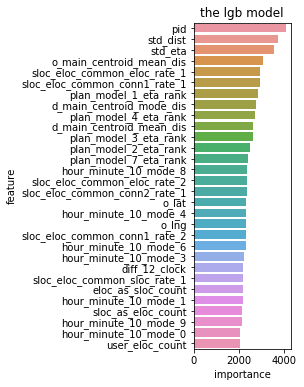

In [42]:
imp = pd.DataFrame()
imp['fea'] = feature
print(len(feature))
print(lgb_model.feature_importances_)
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp.to_csv('../feature_data/feature_import_new.csv')


#绘制特征重要度图
plt.figure(figsize=(8,6))
plt.subplot(142)
col_imp=pd.DataFrame({'feature':imp['fea'],'importance':imp['imp']}).sort_values(by='importance',ascending=False)
sns.barplot(x=col_imp['importance'][0:30],y=col_imp['feature'][0:30],orient='h')
plt.title('the lgb model')

# 特征后处理

# 模型预测和综合

In [43]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

In [75]:
data[xietong_fea].to_csv('../feature_data/xietong_feature_shanghai.csv')

In [107]:
data[use_address_info].to_csv('../feature_data/use_address_info_feature_shanghai.csv')

In [135]:
data

,Unnamed: 0,click_mode,click_time,d,o,pid,plan_time,plans,req_time,sid,...,profile_tf_svd_0,profile_tf_svd_1,profile_tf_svd_2,profile_tf_svd_3,profile_tf_svd_4,profile_tf_svd_5,profile_tf_svd_6,profile_tf_svd_7,profile_tf_svd_8,profile_tf_svd_9
0,500002,2.0,2018-10-06 22:15:31,"121.50,31.24","121.51,31.23",NaN,2018-10-06 22:14:36,"[{""distance"": 2243, ""price"": 300, ""eta"": 1027,...",2018-10-06 22:14:36,702620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500008,1.0,2018-10-07 17:38:05,"121.28,31.38","121.32,31.30",57906.0,2018-10-07 17:38:02,"[{""distance"": 15372, ""price"": 200, ""eta"": 3359...",2018-10-07 17:38:02,640184,...,-0.002543,-0.000151,0.004397,-0.003402,0.002289,0.000850,0.000325,0.000502,-0.003857,0.002169
2,500010,0.0,NaN,"121.45,31.27","121.45,31.25",46141.0,NaN,NaN,2018-11-16 03:41:29,525250,...,-0.000095,0.004790,-0.003030,0.000213,0.000789,-0.003102,0.002509,0.001214,-0.002768,0.004576
3,500011,7.0,2018-10-05 22:21:52,"121.51,31.31","121.28,31.35",NaN,2018-10-05 22:21:42,"[{""distance"": 26344, ""price"": """", ""eta"": 1734,...",2018-10-05 22:21:42,730057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500014,6.0,2018-10-23 20:10:31,"121.25,31.40","121.24,31.40",6197.0,2018-10-23 20:10:28,"[{""distance"": 708, ""price"": """", ""eta"": 656, ""t...",2018-10-23 20:10:28,790201,...,0.005971,0.001707,0.000830,-0.000795,-0.000023,0.003284,-0.000783,0.002426,-0.005211,0.001181
5,500019,2.0,2018-11-13 12:01:44,"121.47,31.20","121.45,31.20",107598.0,2018-11-13 12:01:38,"[{""distance"": 4854, ""price"": 300, ""eta"": 2230,...",2018-11-13 12:01:38,918191,...,-0.000623,0.001716,0.003884,0.005750,-0.000548,0.000896,0.001764,0.001649,-0.001319,0.002561
6,500020,2.0,2018-10-13 06:59:55,"121.36,31.28","121.45,31.25",22024.0,2018-10-13 06:59:51,"[{""distance"": 13236, ""price"": 400, ""eta"": 2467...",2018-10-13 06:59:51,750735,...,-0.001371,-0.000468,-0.000443,0.002480,-0.003227,0.001926,-0.001247,-0.002934,-0.004176,-0.000145
7,500023,2.0,2018-11-02 14:25:27,"121.32,31.20","121.48,31.24",NaN,2018-11-02 14:25:19,"[{""distance"": 19431, ""price"": 500, ""eta"": 2386...",2018-11-02 14:25:19,628200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,500024,2.0,2018-10-07 14:53:21,"121.55,31.23","121.52,31.23",24995.0,2018-10-07 14:53:19,"[{""distance"": 4448, ""price"": 300, ""eta"": 1453,...",2018-10-07 14:53:19,834074,...,0.002637,0.000354,0.004557,0.001713,-0.000720,-0.001096,-0.001442,0.001032,0.002473,0.007416
9,500026,1.0,2018-11-16 14:09:55,"121.26,31.03","121.23,31.02",16342.0,2018-11-16 14:09:53,"[{""distance"": 3500, ""price"": 100, ""eta"": 1412,...",2018-11-16 14:09:53,755990,...,-0.000092,0.000765,0.000781,0.000007,0.000009,0.000934,0.002480,0.003712,0.000247,-0.003287


In [87]:
data

,Unnamed: 0,click_mode,click_time,d,o,pid,plan_time,plans,req_time,sid,...,o_kmeans_eloc_count,o_kmeans_sloc_count,o_kmeans_sloc_eloc_common_eloc_count,o_kmeans_sloc_eloc_common_sloc_count,o_kmeans_sloc_eloc_common_conn1_count,o_kmeans_sloc_eloc_common_conn2_count,o_kmeans_sloc_eloc_common_eloc_rate,o_kmeans_sloc_eloc_common_sloc_rate,o_kmeans_sloc_eloc_common_conn1_rate,o_kmeans_sloc_eloc_common_conn2_rate
0,500002,2.0,2018-10-06 22:15:31,"121.50,31.24","121.51,31.23",NaN,2018-10-06 22:14:36,"[{""distance"": 2243, ""price"": 300, ""eta"": 1027,...",2018-10-06 22:14:36,702620,...,5033,2351,8527,6407,6198,5757,0.901851,0.998131,0.839382,0.678092
1,500008,1.0,2018-10-07 17:38:05,"121.28,31.38","121.32,31.30",57906.0,2018-10-07 17:38:02,"[{""distance"": 15372, ""price"": 200, ""eta"": 3359...",2018-10-07 17:38:02,640184,...,25,825,83,66,79,7,0.095843,0.409938,0.092941,0.039548
2,500010,0.0,NaN,"121.45,31.27","121.45,31.25",46141.0,NaN,NaN,2018-11-16 03:41:29,525250,...,217,10551,0,4719,3767,0,NaN,0.883542,0.349833,NaN
3,500011,7.0,2018-10-05 22:21:52,"121.51,31.31","121.28,31.35",NaN,2018-10-05 22:21:42,"[{""distance"": 26344, ""price"": """", ""eta"": 1734,...",2018-10-05 22:21:42,730057,...,11,21,0,5,0,0,NaN,0.227273,0.000000,NaN
4,500014,6.0,2018-10-23 20:10:31,"121.25,31.40","121.24,31.40",6197.0,2018-10-23 20:10:28,"[{""distance"": 708, ""price"": """", ""eta"": 656, ""t...",2018-10-23 20:10:28,790201,...,53,140,126,59,71,50,0.477273,0.627660,0.367876,0.303030
5,500019,2.0,2018-11-13 12:01:44,"121.47,31.20","121.45,31.20",107598.0,2018-11-13 12:01:38,"[{""distance"": 4854, ""price"": 300, ""eta"": 2230,...",2018-11-13 12:01:38,918191,...,224,2173,0,899,923,0,NaN,0.880509,0.385065,NaN
6,500020,2.0,2018-10-13 06:59:55,"121.36,31.28","121.45,31.25",22024.0,2018-10-13 06:59:51,"[{""distance"": 13236, ""price"": 400, ""eta"": 2467...",2018-10-13 06:59:51,750735,...,6,10551,0,1398,1238,0,NaN,0.272515,0.117268,NaN
7,500023,2.0,2018-11-02 14:25:27,"121.32,31.20","121.48,31.24",NaN,2018-11-02 14:25:19,"[{""distance"": 19431, ""price"": 500, ""eta"": 2386...",2018-11-02 14:25:19,628200,...,6745,11455,0,12728,12930,0,NaN,0.998745,0.710440,NaN
8,500024,2.0,2018-10-07 14:53:21,"121.55,31.23","121.52,31.23",24995.0,2018-10-07 14:53:19,"[{""distance"": 4448, ""price"": 300, ""eta"": 1453,...",2018-10-07 14:53:19,834074,...,435,4808,4417,1738,2597,1707,0.771259,0.962881,0.495327,0.745740
9,500026,1.0,2018-11-16 14:09:55,"121.26,31.03","121.23,31.02",16342.0,2018-11-16 14:09:53,"[{""distance"": 3500, ""price"": 100, ""eta"": 1412,...",2018-11-16 14:09:53,755990,...,41,662,144,106,115,68,0.203678,0.438017,0.163585,0.276423


In [52]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'city_flag', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'req_time_hour', 'req_time_weekday',
       'req_time_minute', 'req_time_date_d', 'time_diff', 'svd_fea_0',
       'svd_fea_1', 'svd_fea_2'

In [62]:
data=data.drop(pid_loc_sta_10, axis=1)
data=data.drop(use_address_info, axis=1)

data.to_csv('feature_shanghai_696427.csv')

In [1]:
data.columns.values

NameError: name 'data' is not defined

# 后处理 参数搜索

In [ ]:
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values

In [ ]:
def proba_process(valid_proba):
    val_pred_y = []
    #这里row这个点，真的是坑死了
    for index,row in enumerate(valid_proba):
        row1=[[0]*13][0]
        #print(row)
        if row[0] >= 0.423862:
            row1[0] = 1
        if row[1] >= 0.3462:
            row1[1] = 1
        if row[2] >= 0.3872:
            row1[2] = 1
        if row[3] >= 0.1343:
            row1[3] = 1
        if row[4] >= 0.0744:
            row1[4] = 1
        if row[5] > 0.4296:
            row1[5] = 1
        if row[6] > 0.2025:
            row1[6] = 1
        if row[7] > 0.41940:
            row1[7] = 1
        if row[8] > 0.2085:
            row1[8] = 1
        if row[9] >  0.3233:
            row1[9] = 1  
        if row[10] > 0.2353:
            row1[10] = 1
        if row[11] > 0.2383:
            row1[11] = 1
        val_pred_y.append(np.argmax(row1))
    return val_pred_y

In [ ]:
import gc
gc.collect()
df_analysis['pred']  = proba_process(valid_prob_df.values)   
df_analysis['label'] = df_analysis['label'].astype(int)
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
#print('dic_:',dic_)

def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
#         print('dic_[i]:',dic_[i])        
#         print('yt:',yt)
#         print('yp:',yp)
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

In [4]:
dist_feat = ['plan_model_%d_dist' % i for i in range(1, 12)]
price_feat = ['plan_model_%d_price' % i for i in range(1, 12)]
eta_feat = ['plan_model_%d_eta' % i for i in range(1, 12)]
rank_feat = ['plan_model_%d_rank' % i for i in range(1, 12)]

plans = data[dist_feat + price_feat + eta_feat+rank_feat+['click_mode']]
plans

,plan_model_1_dist,plan_model_2_dist,plan_model_3_dist,plan_model_4_dist,plan_model_5_dist,plan_model_6_dist,plan_model_7_dist,plan_model_8_dist,plan_model_9_dist,plan_model_10_dist,...,plan_model_3_rank,plan_model_4_rank,plan_model_5_rank,plan_model_6_rank,plan_model_7_rank,plan_model_8_rank,plan_model_9_rank,plan_model_10_rank,plan_model_11_rank,click_mode
0,2477.0,2243.0,2539.0,2539.0,1889.0,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
1,15372.0,NaN,NaN,NaN,NaN,NaN,16876.0,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
3,37768.0,NaN,26344.0,26344.0,NaN,NaN,54087.0,NaN,NaN,NaN,...,0.0,1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,7.0
4,871.5,NaN,NaN,NaN,708.0,716.0,NaN,NaN,NaN,NaN,...,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
5,4054.0,4854.0,NaN,3697.0,3272.0,3527.0,NaN,NaN,NaN,NaN,...,-1.0,1.0,4.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
6,11609.0,13236.0,16959.0,16959.0,NaN,NaN,NaN,NaN,NaN,14017.0,...,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,2.0
7,NaN,19431.0,22588.0,22588.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
8,4444.0,4448.0,3770.0,3770.0,3736.0,4356.0,NaN,NaN,NaN,NaN,...,1.0,2.0,5.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
9,3500.0,NaN,3777.0,3777.0,3363.0,3438.0,NaN,NaN,NaN,NaN,...,1.0,2.0,4.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


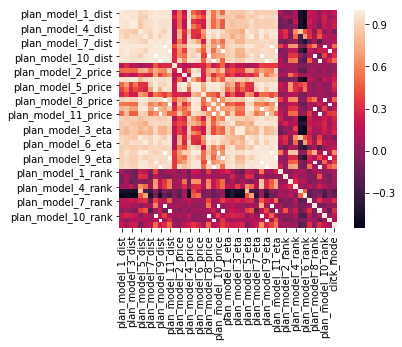

In [7]:
import seaborn as sns

sns.heatmap(plans.corr(), vmax=1, square=True)

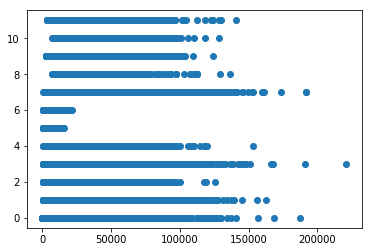

In [8]:
#可以发现   plan_model_1_dist 对 不同类别的click_mode   区分度是非常小的
plt.scatter(plans['plan_model_1_dist'],plans['click_mode'])

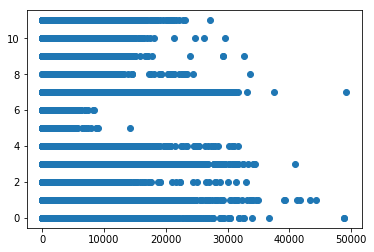

In [10]:
plt.scatter(data['std_dist'],plans['click_mode'])

In [1]:
import gc
gc.collect()

35